In [53]:
# set keras 3 backend to pytorch and enable cuda
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("keras backend:", keras.backend.backend())
print("pytorch cuda available:", torch.cuda.is_available())
print("selected device:", device)

keras backend: torch
pytorch cuda available: True
selected device: cuda


In [54]:
import os, random, numpy as np

np.random.seed(13)
random.seed(13)
import sys, os
sys.path.append(os.path.abspath("../src"))

['date', 'maturity', 'tau', 'S0', 'K', 'rel_strike', 'q', 'r', 'market_iv', 'rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7', 'rf_8', 'rf_9', 'rf_10', 'rf_11', 'rf_12', 'rf_13', 'rf_14', 'rf_15', 'rf_16', 'rf_17', 'rf_18', 'rf_19', 'rf_20', 'rf_21', 'rf_22', 'rf_23', 'rf_24', 'rf_25', 'rf_26', 'rf_27', 'rf_28', 'rf_29', 'rf_30', 'rf_31', 'ssvi_theta', 'ssvi_rho', 'ssvi_beta', 'heston_kappa', 'heston_theta', 'heston_sigma', 'heston_rho', 'heston_v0']
(141790, 49)


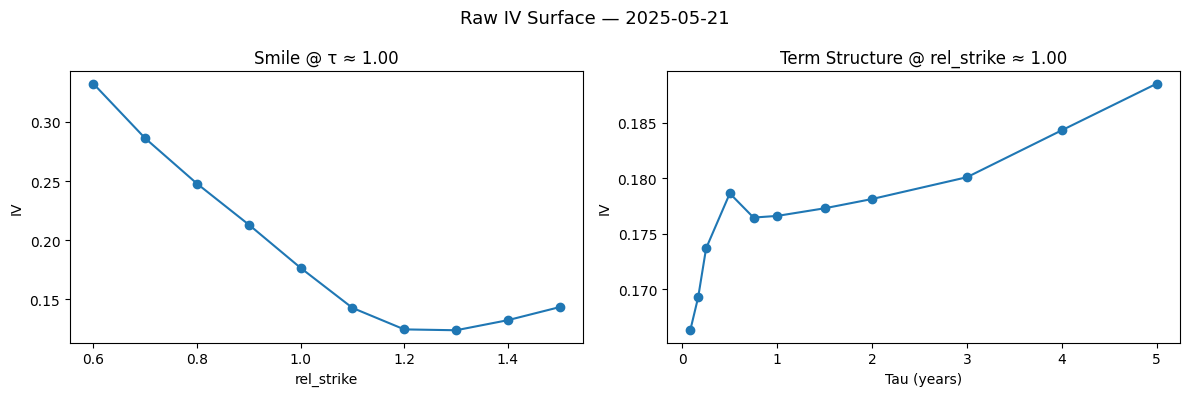

In [55]:
from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")

print(df.columns.tolist())
print(df.shape)

# global variables
global LOOKBACK, BATCH_SIZE, LATENT_DIM, SURFACE_SHAPE, FEATURE_DIM
global TARGET_DATE, TARGET_STRIKE, TARGET_TAU

LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)  

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False

from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)

In [56]:
from data.dataset_builder import build_full_surface_feature_df

df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")



print(" Final DataFrame shape:", df_all.shape)
print(" First 5 dates:", df_all.index[:5].tolist())

iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print(" Surface cols:", len(iv_cols), "|  Feature cols:", len(feat_cols))
print("Surface columns (sample):", iv_cols[:5])
print("Feature columns (sample):", feat_cols[:5])

nan_summary = df_all[feat_cols].isna().sum()
nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)
print("Features with NaNs:\n", nan_summary)




 Final DataFrame shape: (1289, 136)
 First 5 dates: [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-16 00:00:00')]
 Surface cols: 110 |  Feature cols: 26
Surface columns (sample): ['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00']
Feature columns (sample): ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20']
Features with NaNs:
 Series([], dtype: int64)


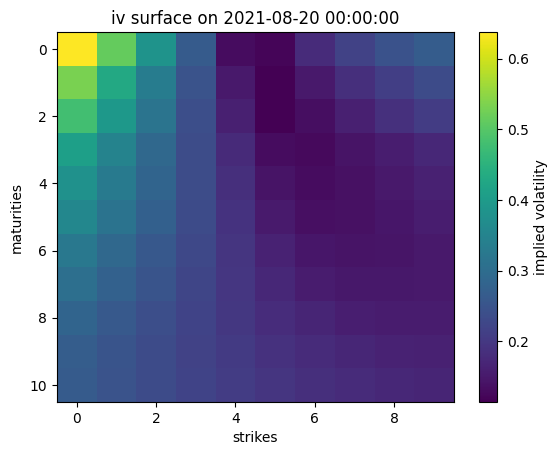


iv surface table on 2021-08-20 00:00:00


strike       0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
maturity                                                                   
18m       0.6376  0.5133  0.3838  0.2646  0.1324  0.1212  0.1786  0.2184   
1m        0.5325  0.4293  0.3344  0.2475  0.1495  0.1147  0.1501  0.1851   
1y        0.4786  0.3935  0.3153  0.2411  0.1601  0.1167  0.1347  0.1615   
2m        0.4097  0.3476  0.2914  0.2358  0.1763  0.1322  0.1286  0.1413   
2y        0.3799  0.3293  0.2828  0.2359  0.1855  0.1433  0.1323  0.1387   
3m        0.3563  0.3141  0.2745  0.2341  0.1908  0.1520  0.1367  0.1385   
3y        0.3249  0.2915  0.2597  0.2276  0.1947  0.1646  0.1467  0.1418   
4y        0.3062  0.2774  0.2501  0.2234  0.1968  0.1725  0.1554  0.1479   
5y        0.2830  0.2605  0.2394  0.2192  0.1998  0.1821  0.1683  0.1592   
6m        0.2697  0.2512  0.2341  0.2182  0.2031  0.1895  0.1785  0.1702   
9m        0.2642  0.2481  0.2333  0.2196  0.2069  0.1955  0.1860  0.1784   

strike       1.4     1.5  
maturity                  
18m       0.2459  0.2661  
1m        0.2127  0.2338  
1y        0.1863  0.2070  
2m        0.1570  0.1729  
2y        0.1498  0.1619  
3m        0.1464  0.1561  
3y        0.1442  0.1496  
4y        0.1477  0.1507  
5y        0.1551  0.1547  
6m        0.1651  0.1627  
9m        0.1728  0.1693

In [57]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

# select random date
ix = np.random.randint(len(df_all))
date = df_all.index[ix]

# parse shape from iv column names
maturities = sorted(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# extract and reshape surface
surface_values = df_all.iloc[ix][iv_cols].values.reshape(len(maturities), len(strikes))

# plot
plt.imshow(surface_values, cmap="viridis", aspect="auto")
plt.title(f"iv surface on {date}")
plt.xlabel("strikes")
plt.ylabel("maturities")
plt.colorbar(label="implied volatility")
plt.show()

# display surface table
surface_df = pd.DataFrame(surface_values, index=maturities, columns=strikes)
surface_df.index.name = "maturity"
surface_df.columns.name = "strike"

print(f"\niv surface table on {date}")
display(surface_df.round(4))

In [58]:
from data.tensor_builder import prepare_surface_and_feature_tensors
from keras import ops

# build vol tensors and interpolation functions
tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df,
    feat_cols=feat_cols,
    monthly_interpolation=False  # or true
)

# output summary
print("structured tensors loaded and interpolated")
print("surface_tensor shape:", ops.shape(tensors["surface_tensor"]))
print("X_feat_tensor shape:", ops.shape(X_feat_tensor))
print("number of taus:", len(tensors["taus"]))
print("feature columns:", df_feat.columns.tolist())

structured tensors loaded and interpolated
surface_tensor shape: (1258, 11, 10, 6)
X_feat_tensor shape: (1258, 136)
number of taus: 11
feature columns: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20', 'realized_vol_5d_z20', 'rate_0.25y', 'rate_0.5y', 'rate_1y', 'rate_2y', 'rate_3y', 'rate_4y', 'rate_5y', 'rate_10y', 'rate_30y', 'slope_5_10', 'slope_10_30', 'smile_skew', 'smile_convexity', 'ts_level', 'ts_slope', 'ts_curvature', 'ts_weighted', 'ts_short_avg', 'ts_long_avg', 'ts_split_slope']


In [59]:
import importlib
import data.dataset
importlib.reload(data.dataset)

from data.tensor_builder import split_time_series_indices, slice_tensors
from data.dataset import FeatureToLatentSequenceDataset
from keras import ops
import pandas as pd

# split time indices
T = tensors["surface_tensor"].shape[0]
train_idx, val_idx, test_idx = split_time_series_indices(T)

train = slice_tensors(tensors, train_idx)
val   = slice_tensors(tensors, val_idx)
test  = slice_tensors(tensors, test_idx)

LOOKBACK = 20
BATCH_SIZE = 32

# datasets with global index tracking
train_dataset = FeatureToLatentSequenceDataset(
    surface_tensor=train["surface_tensor"],
    feature_tensor=X_feat_tensor[train_idx],
    lookback=LOOKBACK,
    batch_size=BATCH_SIZE,
    global_indices=train_idx
)

val_dataset = FeatureToLatentSequenceDataset(
    surface_tensor=val["surface_tensor"],
    feature_tensor=X_feat_tensor[val_idx],
    lookback=LOOKBACK,
    batch_size=BATCH_SIZE,
    global_indices=val_idx
)

test_dataset = FeatureToLatentSequenceDataset(
    surface_tensor=test["surface_tensor"],
    feature_tensor=X_feat_tensor[test_idx],
    lookback=LOOKBACK,
    batch_size=BATCH_SIZE,
    global_indices=test_idx
)

# inspect one batch to confirm structure
sample = next(iter(train_dataset))

print("batch from train_dataset")
print("type:", type(sample))
print("len:", len(sample))

x, y = sample
print("\ninput tuple (x):", type(x), "length:", len(x))
print("  x[0] (surf_seq) shape:", x[0].shape)
print("  x[1] (feat_seq) shape:", x[1].shape)

print("\ntarget (y):", type(y), "shape:", y.shape)

# global diagnostics
M, K = tensors["surface_tensor"].shape[1:3]
flat_len = M * K

print(f"\ndataset shapes and diagnostics:")
print(f"  train_dataset batches: {len(train_dataset)}")
print(f"  val_dataset batches: {len(val_dataset)}")
print(f"  test_dataset batches: {len(test_dataset)}")
print(f"  iv surface dim (m, k): ({M}, {K})")

# check target date location
target_date = pd.Timestamp("2025-05-21")
idx = np.where(tensors["date_tensor"] == target_date)[0][0]
print("\ndate check")
print("target global index:", idx)
print("in test?", idx in test_dataset.global_indices)
print("train:", train_idx[[0, -1]])
print("val:", val_idx[[0, -1]])
print("test:", test_idx[[0, -1]])

batch from train_dataset
type: <class 'tuple'>
len: 2

input tuple (x): <class 'tuple'> length: 2
  x[0] (surf_seq) shape: torch.Size([32, 20, 11, 10, 6])
  x[1] (feat_seq) shape: torch.Size([32, 20, 136])

target (y): <class 'torch.Tensor'> shape: torch.Size([32, 11, 10, 6])

dataset shapes and diagnostics:
  train_dataset batches: 26
  val_dataset batches: 5
  test_dataset batches: 5
  iv surface dim (m, k): (11, 10)

date check
target global index: 1257
in test? True
train: [  0 879]
val: [ 880 1068]
test: [1069 1257]


Using 1258 valid samples out of 1258
FW-PCA reconstruction RMSE (surface only): 0.0037


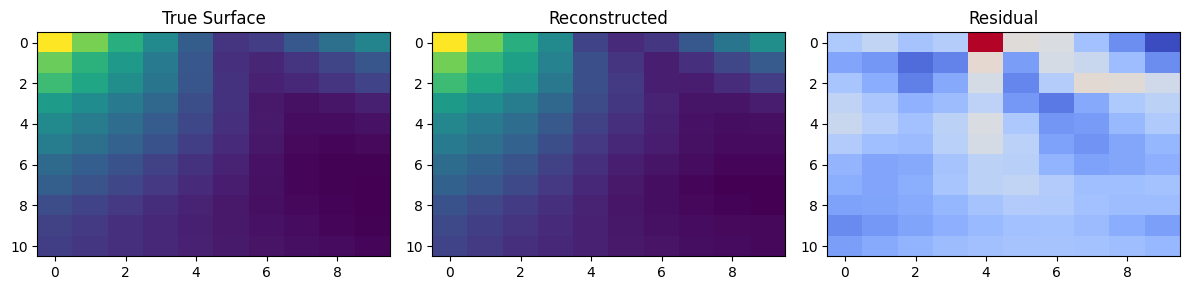

In [60]:
import importlib
import models.fw_pca
importlib.reload(models.fw_pca)

from models.fw_pca import FeatureWeightedPCA, FWPCAEncoderWrapper
from sklearn.metrics import mean_squared_error
from keras import ops
import numpy as np
import matplotlib.pyplot as plt

surface_np = ops.convert_to_numpy(tensors["surface_tensor"])
features_np = ops.convert_to_numpy(X_feat_tensor)
dates_np = tensors["date_tensor"]

T, M, K, C = surface_np.shape
X_surface = surface_np[..., -1].reshape(T, M * K).astype("float32")
X_features = features_np.astype("float32")

X_combined = np.hstack([X_surface, X_features])

valid_mask = np.all(np.isfinite(X_combined), axis=1)
X_surface_valid = X_surface[valid_mask]
X_features_valid = X_features[valid_mask]
dates_valid = np.array(dates_np)[valid_mask]

print(f"Using {len(X_surface_valid)} valid samples out of {T}")

fw_pca = FeatureWeightedPCA(n_components=LATENT_DIM)
fw_pca.fit(ops.convert_to_tensor(X_surface_valid), ops.convert_to_tensor(X_features_valid))

encoder = FWPCAEncoderWrapper(fw_pca, ops.convert_to_tensor(X_features_valid), M, K)

Z = encoder.fit_transform(np.hstack([X_surface_valid, X_features_valid]))
X_recon_surface = encoder.inverse_transform(Z)

rmse_surface = np.sqrt(mean_squared_error(X_surface_valid, X_recon_surface))
print(f"FW-PCA reconstruction RMSE (surface only): {rmse_surface:.4f}")

ix = 0
X_true = X_surface_valid[ix].reshape(M, K)
X_pred = X_recon_surface[ix].reshape(M, K)
residual = X_true - X_pred

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(X_true, cmap="viridis", aspect="auto")
axs[0].set_title("True Surface")
axs[1].imshow(X_pred, cmap="viridis", aspect="auto")
axs[1].set_title("Reconstructed")
axs[2].imshow(residual, cmap="coolwarm", aspect="auto")
axs[2].set_title("Residual")
plt.tight_layout()
plt.show()

encoder latent dim: 12
GBO-VAR surface RMSE_σ: 0.0005


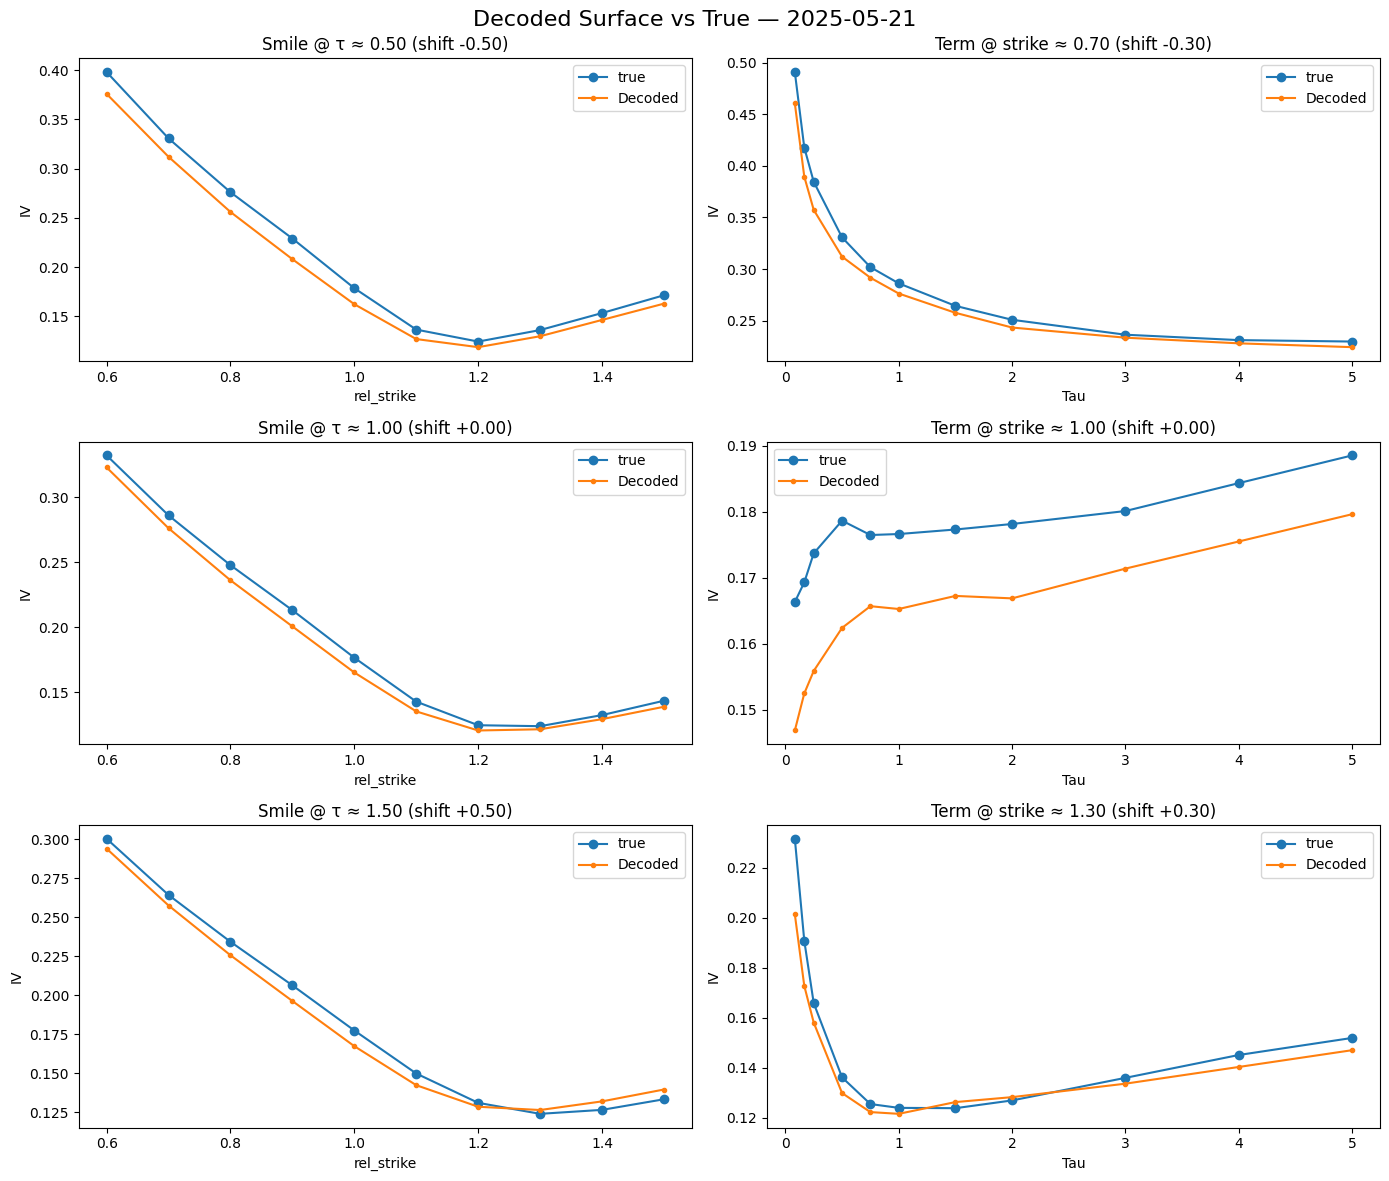

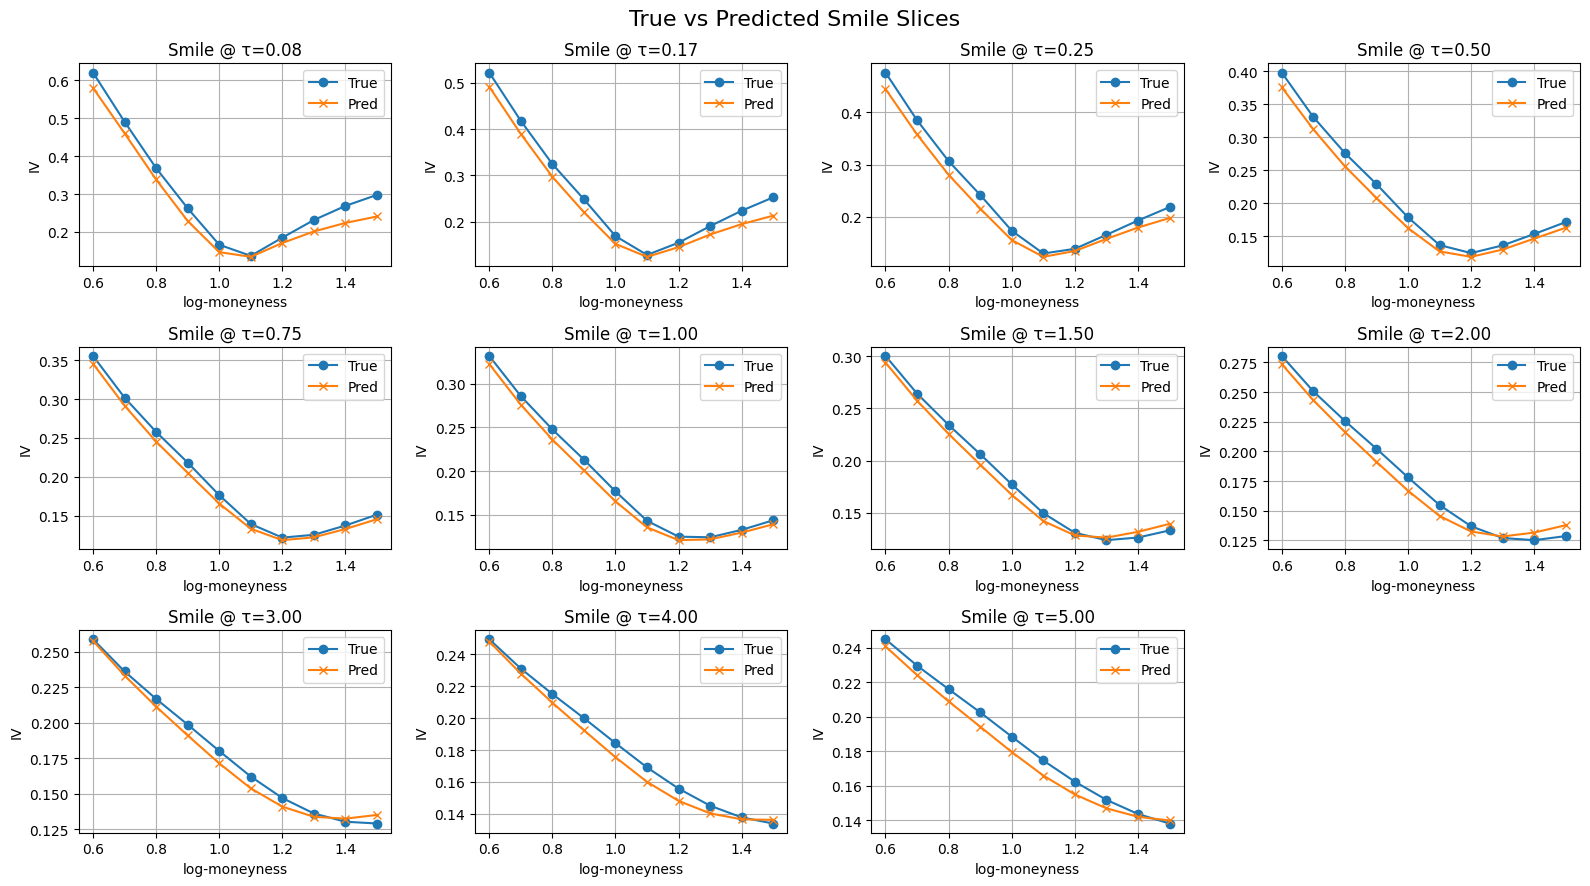

In [61]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from keras import ops
import numpy as np
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison
import importlib
import models.fw_pca
importlib.reload(models.fw_pca)
from models.fw_pca import FeatureWeightedPCA, FWPCAEncoderWrapper

iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]
T, M, K = iv_surface.shape
X_flat = iv_surface.reshape(T, M * K)

F = ops.convert_to_numpy(X_feat_tensor)
X_combined = np.hstack([X_flat, F])

valid_mask = np.all(np.isfinite(X_combined), axis=1)
X_valid_flat = X_flat[valid_mask]
F_valid = F[valid_mask]
X_combined_valid = X_combined[valid_mask]

fwpca = FeatureWeightedPCA(n_components=12)
fwpca.fit(ops.convert_to_tensor(X_valid_flat), ops.convert_to_tensor(F_valid))
encoder = FWPCAEncoderWrapper(fwpca, ops.convert_to_tensor(F_valid), M, K)
print("encoder latent dim:", encoder.fit_transform(X_combined_valid).shape[1])

Z_all = encoder.fit_transform(X_combined_valid)
Z_mean = Z_all.mean(axis=0, keepdims=True)
Z_centered = Z_all - Z_mean
Z_aug = np.concatenate([Z_centered, F_valid], axis=1)

T_valid = len(Z_aug)
T_train = int(0.7 * T_valid)
Z_train, Z_test = Z_aug[:T_train], Z_aug[T_train:]
Z_train_pure = Z_centered[:T_train]

var_model = VAR(Z_train)
var_results = var_model.fit(maxlags=5)
Z_forecast = var_results.forecast(Z_train[-var_results.k_ar:], steps=len(Z_test))

Z_forecast_pure = Z_forecast[:, :Z_all.shape[1]] + Z_mean
X_recon_surface = encoder.inverse_transform(Z_forecast_pure)

X_true_surface = X_valid_flat[T_train:T_train + len(Z_forecast_pure)]

X_recon = X_recon_surface.reshape(-1, M, K)
X_true = X_true_surface.reshape(-1, M, K)

rmse_surface = mean_squared_error(
   X_true.reshape(-1, M * K),
   X_recon.reshape(-1, M * K)
)
print(f"GBO-VAR surface RMSE_σ: {rmse_surface:.4f}")

true_surface_t = X_true[-1].reshape(*SURFACE_SHAPE)
recon_surface_t = X_recon[-1].reshape(*SURFACE_SHAPE)

plot_iv_slices_shifts(
   true_surface=true_surface_t,
   decoded_surface=recon_surface_t,
   taus=tensors["taus"],
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   decoded_date=TARGET_DATE,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE,
)

plot_smile_slices_comparison(
   true_surface=true_surface_t,
   pred_surface=recon_surface_t,
   rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
   taus=tensors["taus"],
)

In [62]:
import importlib
import models.lstm
importlib.reload(models.lstm)
from models.lstm import build_lstm_forecaster_augmented

lr = 5e-4
input_dim = X_feat_tensor.shape[-1] + LATENT_DIM  # features + encoded surface

lstm_model = build_lstm_forecaster_augmented(
    lookback=LOOKBACK,
    input_dim=LATENT_DIM,      
    latent_dim=LATENT_DIM,
    lr=lr
)


lstm_model.summary()


Model: "lstm_forecaster_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_sequence_input           │ (None, 20, 12)         │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_output (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,548 (256.05 KB)

 Trainable params: 65,548 (256.05 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
import importlib
import models.lstm
importlib.reload(models.lstm)

import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.saving import load_model
from models.lstm import EncodedLatentSequence
import models.fw_pca
importlib.reload(models.fw_pca)
from models.fw_pca import FeatureWeightedPCA, FWPCAEncoderWrapper

#  Load GBO encoder  if not saved, recreate it:
fwpca = FeatureWeightedPCA(n_components=12)
fwpca.fit(ops.convert_to_tensor(X_valid_flat), ops.convert_to_tensor(F_valid))
encoder = FWPCAEncoderWrapper(fwpca, ops.convert_to_tensor(F_valid), M, K)

lr = 5e-4
lstm_model.optimizer = Adam(learning_rate=lr)
lstm_model.compile(optimizer=lstm_model.optimizer, loss="mse")

os.makedirs("saved_models/lstm", exist_ok=True)

callbacks = [
   EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
   ModelCheckpoint("saved_models/lstm/lstm_fwpca.weights.h5",
                   monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

train_gen = EncodedLatentSequence(train_dataset, encoder)
val_gen   = EncodedLatentSequence(val_dataset, encoder)

history_lstm = lstm_model.fit(
   x=train_gen,
   validation_data=val_gen,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

lstm_model.save("saved_models/lstm/lstm_model_fwpca.keras")

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0061 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0023 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0018 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0016 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0016 - val_loss: 0.0020 - learning_rate: 5.0000e-04
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0015 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0015 - val_loss: 0.0012 - 

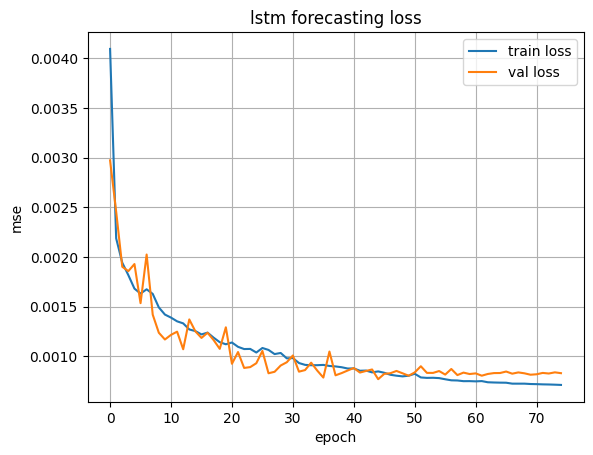

In [64]:
import matplotlib.pyplot as plt

plt.plot(history_lstm.history["loss"], label="train loss")
plt.plot(history_lstm.history["val_loss"], label="val loss")
plt.title("lstm forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  \
0  LSTM-FW-PCA (test)          0.002884            0.002884   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.014301       0.107198             0.644414

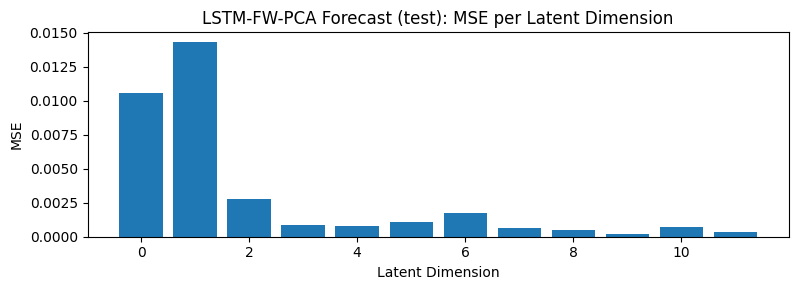

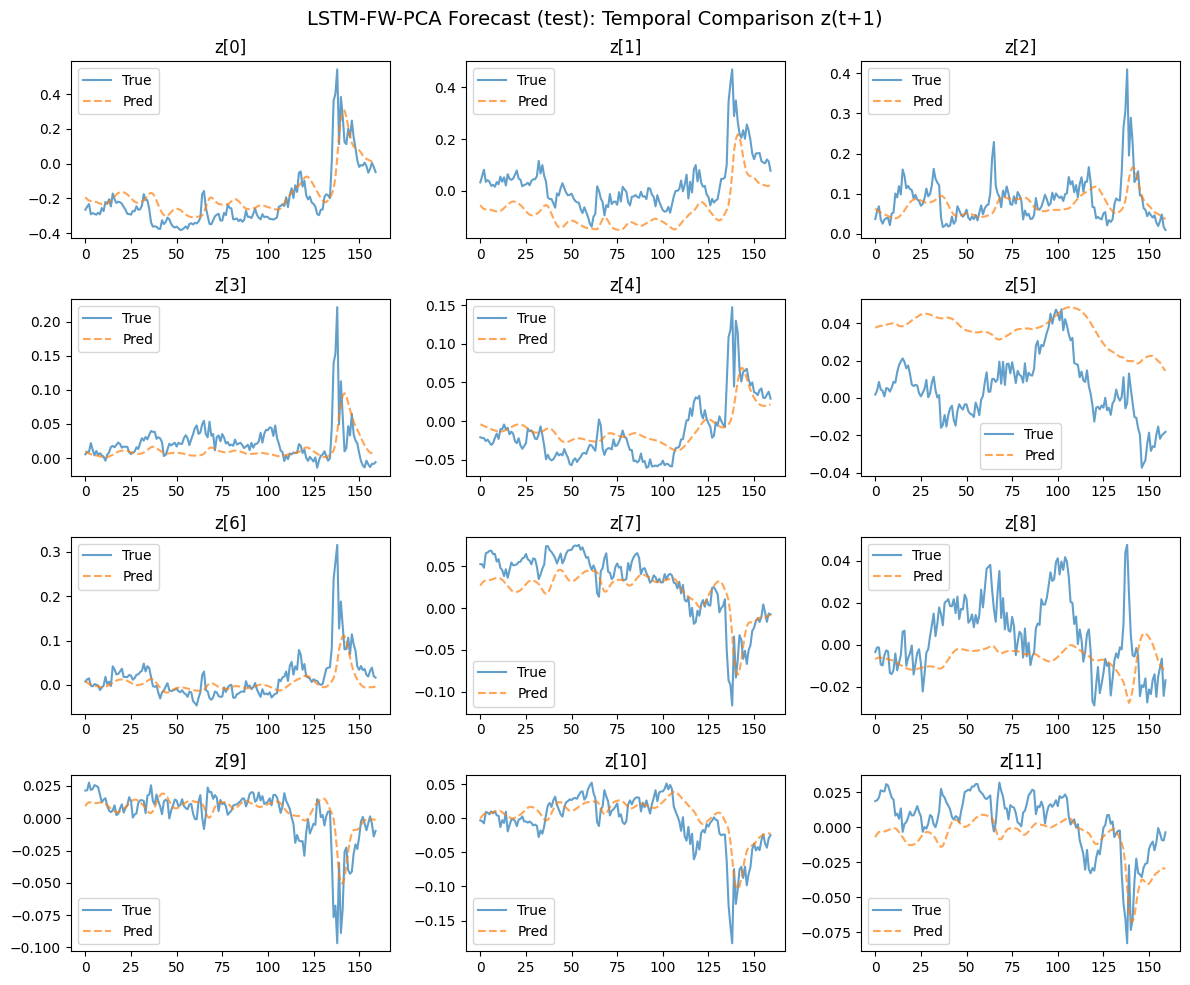

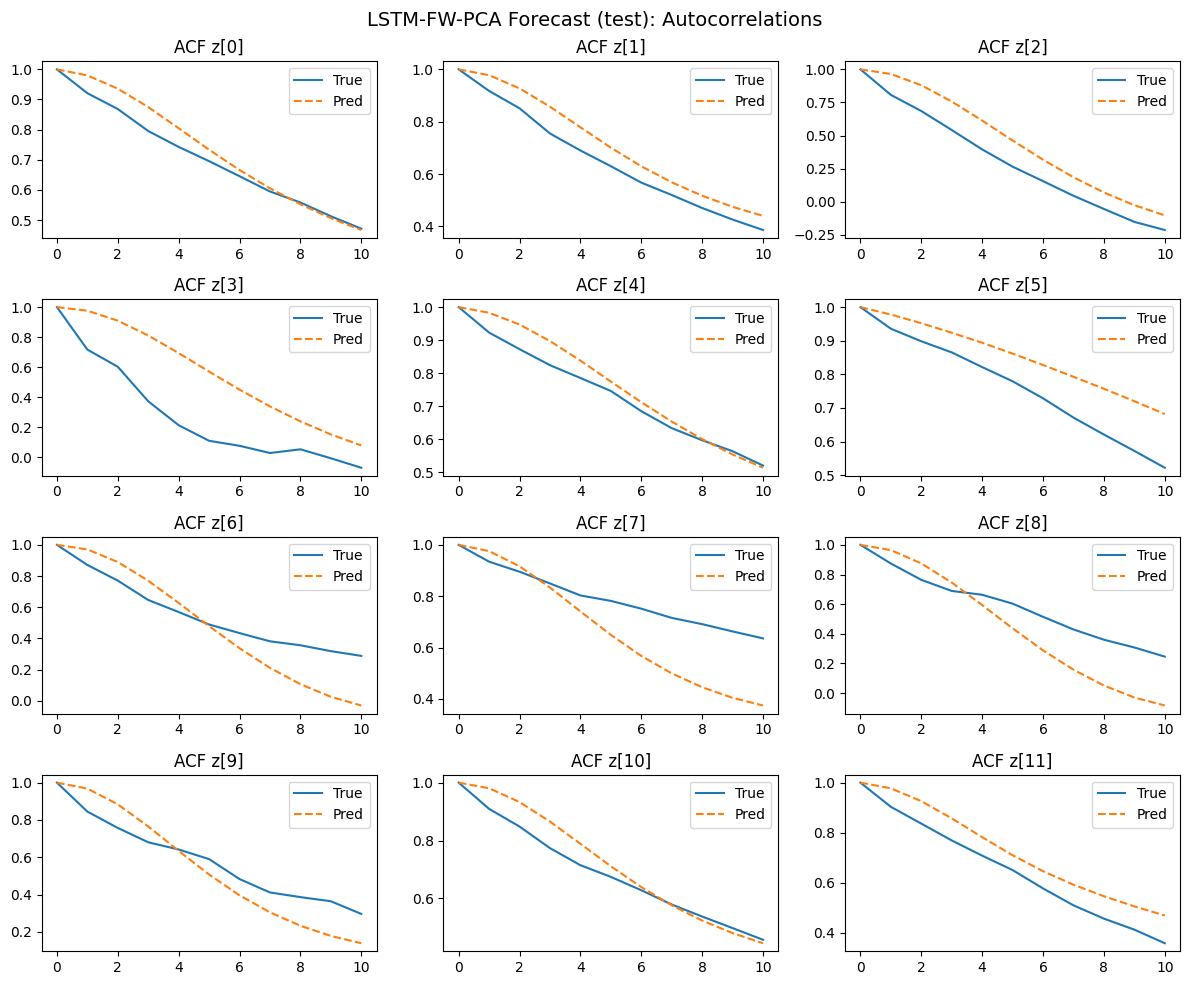

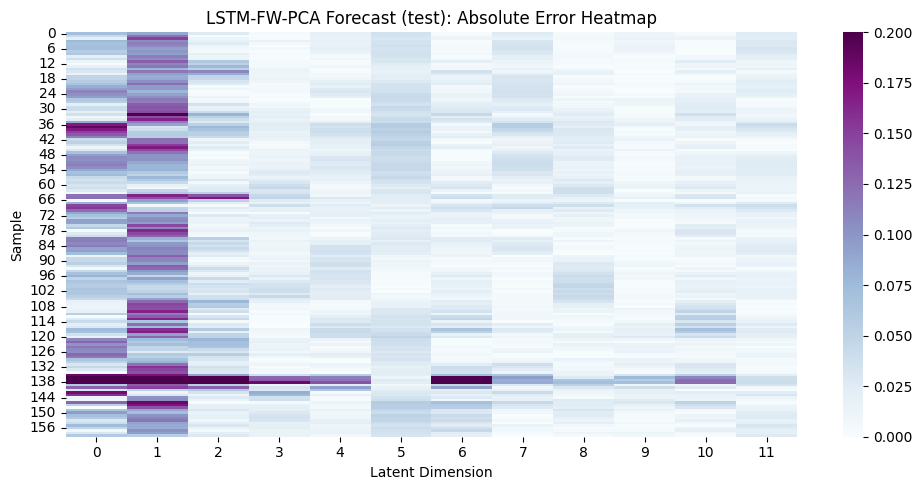

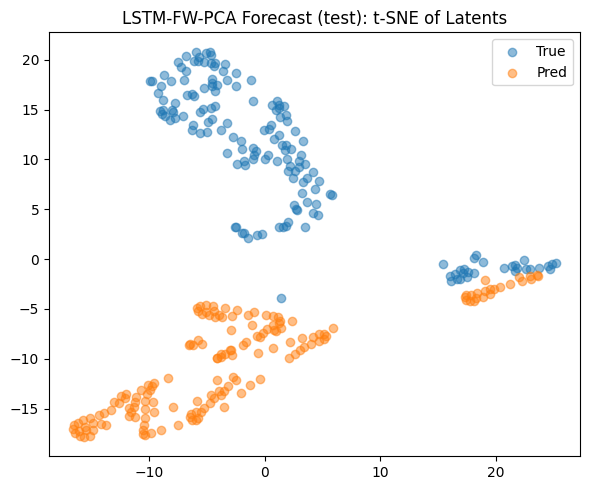

In [65]:
from models.lstm import EncodedLatentSequence
from utils.eval import summarize_latent_errors
from utils.plotting import plot_latent_diagnostics

test_gen = EncodedLatentSequence(test_dataset, encoder)

Z_pred_test = lstm_model.predict(test_gen, verbose=0)
Z_true_test = ops.convert_to_numpy(ops.concatenate([y for _, y in test_gen], axis=0))[:len(Z_pred_test)]

summary_lstm = summarize_latent_errors(Z_true_test, Z_pred_test, name="LSTM-FW-PCA (test)")
display(summary_lstm)

plot_latent_diagnostics(Z_true_test, Z_pred_test, name="LSTM-FW-PCA Forecast (test)", tsne=True)

In [92]:
import importlib
import models.lstm
importlib.reload(models.lstm)

from models.lstm import build_lstm_with_attention_augmented

lr = 5e-4
input_dim = LATENT_DIM  # since z_seq already encodes [surface ⨁ features]

lstm_model = build_lstm_with_attention_augmented(
    lookback=LOOKBACK,
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    lr=lr
)

lstm_model.summary()


Model: "lstm_with_attention_augmented"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_sequence_in… │ (None, 20, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 20, 64)    │     19,712 │ latent_sequence_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 20, 64)    │     33,024 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 20, 32)    │     12,416 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 20, 32)    │          0 │ lstm_8[0][0],     │
│ (Attention)         │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 32)        │          0 │ attention_1[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_output (Dense)    │ (None, 12)        │        396 │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,548 (256.05 KB)

 Trainable params: 65,548 (256.05 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from models.lstm import EncodedLatentSequence

os.makedirs("saved_models/lstm_attn", exist_ok=True)

lr= 5e-4
new_optimizer = Adam(learning_rate=lr)
lstm_model.compile(optimizer=new_optimizer, loss="mse")

callbacks = [
   EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
   ModelCheckpoint("saved_models/lstm_attn/lstm_attn_fwpca.weights.h5",
                   monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

train_gen = EncodedLatentSequence(train_dataset, encoder)
val_gen   = EncodedLatentSequence(val_dataset, encoder)

history_lstm_attn = lstm_model.fit(
   x=train_gen,
   validation_data=val_gen,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

lstm_model.save("saved_models/lstm_attn/lstm_attn_fwpca.keras")

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0059 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0034 - val_loss: 0.0033 - learning_rate: 5.0000e-04
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0025 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0028 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0023 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0021 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0018 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0019 - val_loss: 0.0017 - learning_rate: 5.0000e-04
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0019 - val_loss: 0.0025 - 

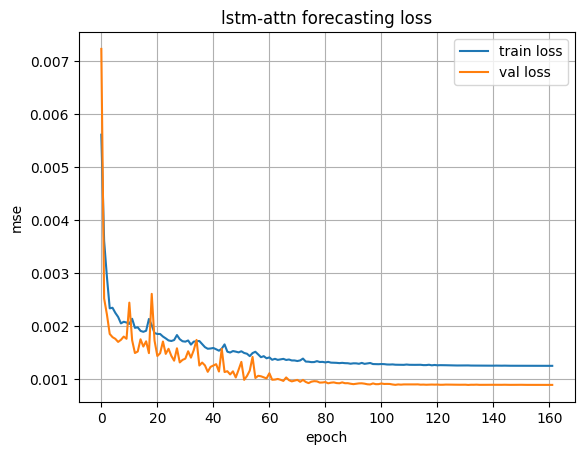

In [68]:
import matplotlib.pyplot as plt

plt.plot(history_lstm_attn.history["loss"], label="train loss")
plt.plot(history_lstm_attn.history["val_loss"], label="val loss")
plt.title("lstm-attn forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  \
0  LSTM-Attn-FW-PCA (test)          0.004696            0.004696   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.022497        0.12593             0.631869

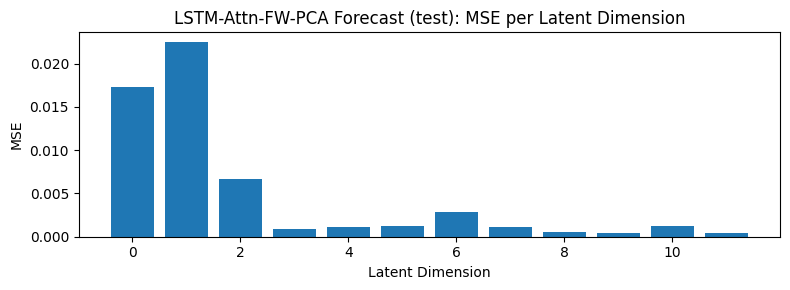

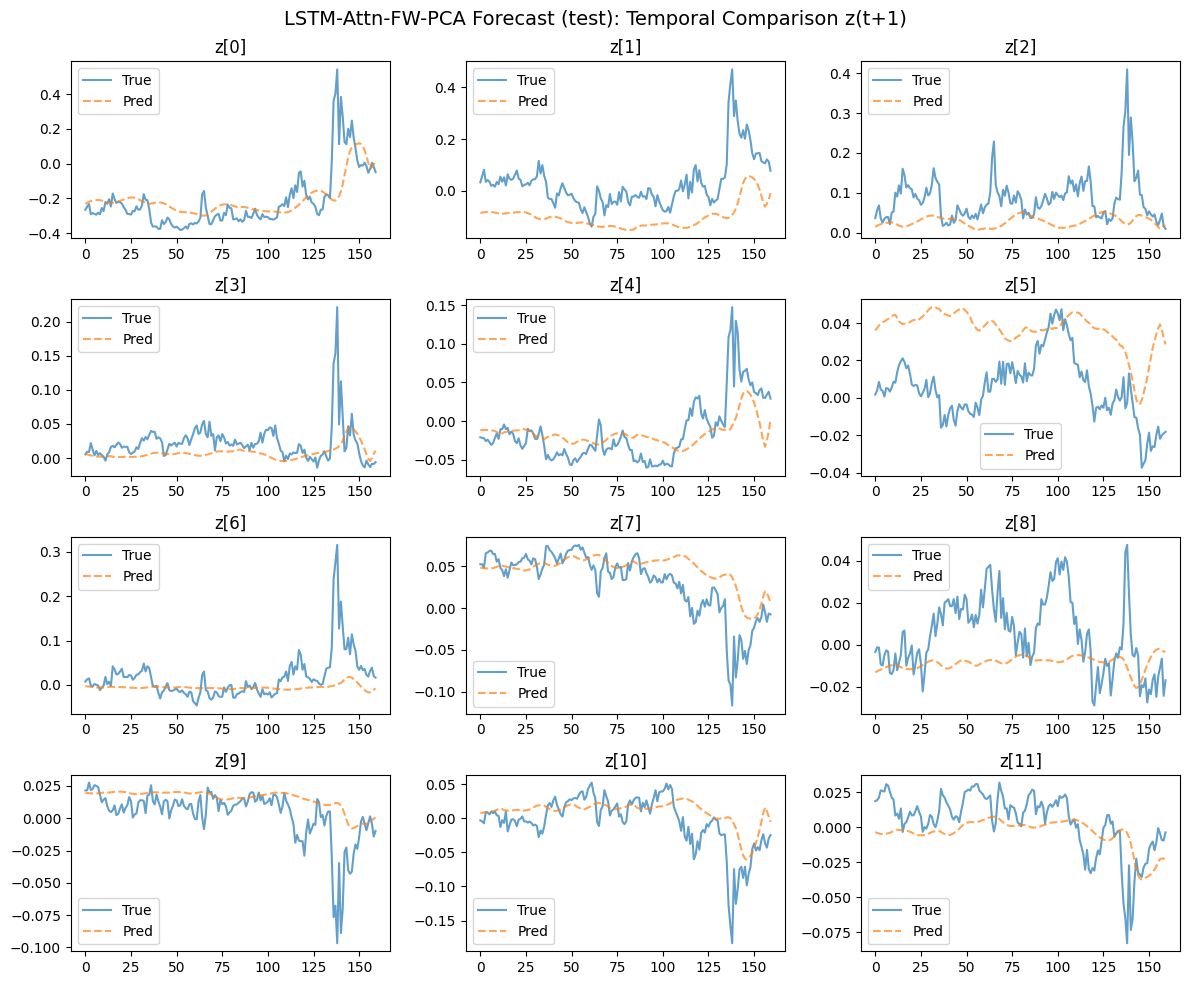

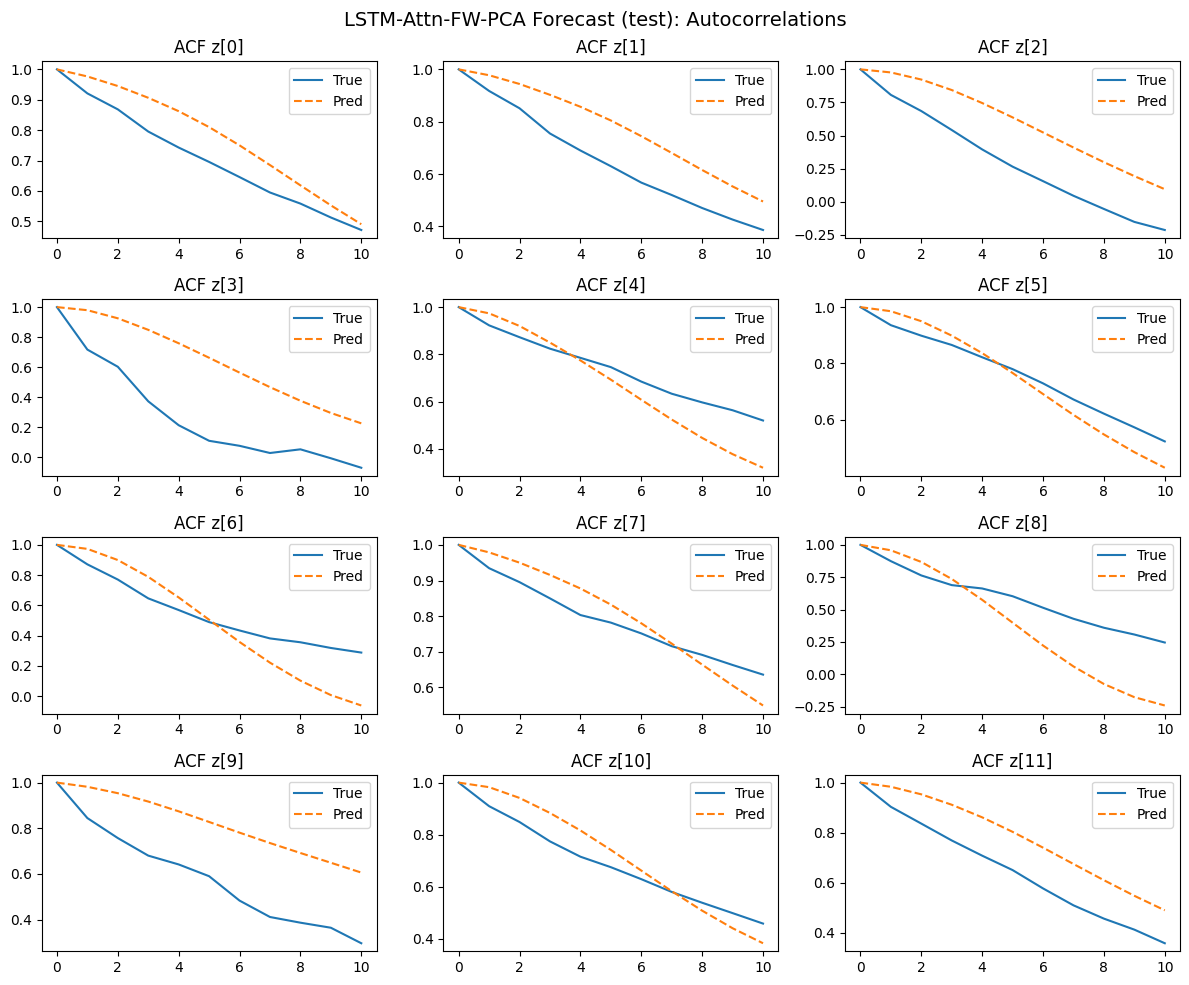

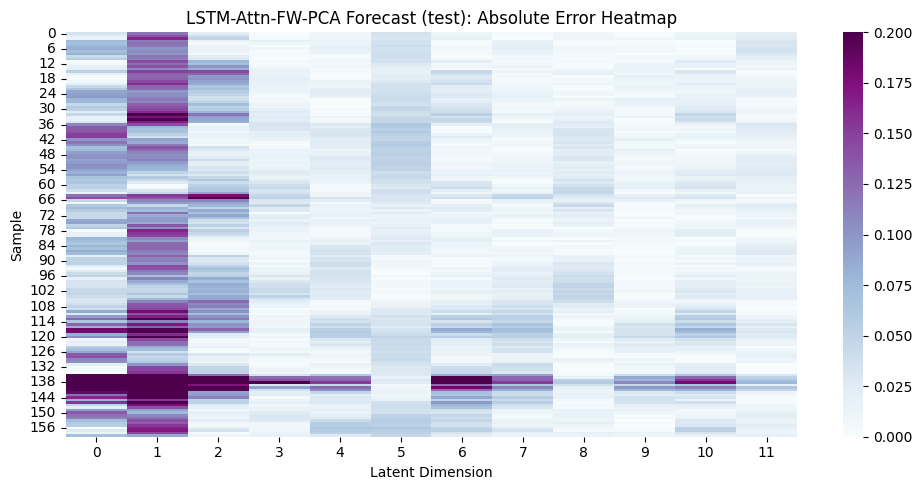

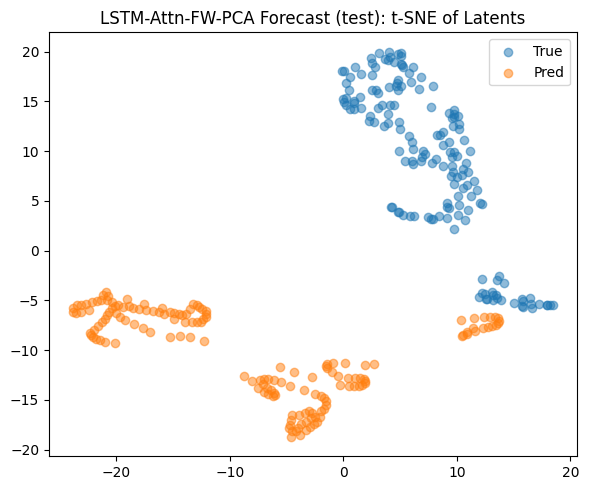

In [69]:
from models.lstm import EncodedLatentSequence
from utils.eval import summarize_latent_errors
from utils.plotting import plot_latent_diagnostics

test_gen = EncodedLatentSequence(test_dataset, encoder)

Z_pred_test = lstm_model.predict(test_gen, verbose=0)

Z_true_test_all = ops.convert_to_numpy(ops.concatenate([y for _, y in test_gen], axis=0))
Z_true_test = Z_true_test_all[:len(Z_pred_test)]

summary_lstm_attn = summarize_latent_errors(Z_true_test, Z_pred_test, name="LSTM-Attn-FW-PCA (test)")
display(summary_lstm_attn)

plot_latent_diagnostics(Z_true_test, Z_pred_test, name="LSTM-Attn-FW-PCA Forecast (test)", tsne=True)

In [70]:
import pandas as pd

def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    #
)

display(summary_all)



model  latent_mse_total  latent_mse_avg_dim  \
0       LSTM-FW-PCA (test)          0.002884            0.002884   
1  LSTM-Attn-FW-PCA (test)          0.004696            0.004696   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.014301       0.107198             0.644414  
1            0.022497       0.125930             0.631869

In [71]:
import models.transformer
importlib.reload(models.transformer)

from models.transformer import build_attention_forecaster

attention_model = build_attention_forecaster(
    lookback=LOOKBACK,
    input_dim=LATENT_DIM,
    latent_dim=LATENT_DIM,
    lr=5e-4,
    dropout=0.0,
    use_layernorm=False  # 
)



attention_model.summary()


Model: "attention_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 20, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 12)    │      2,460 │ sequence_input[0… │
│ (MultiHeadAttentio… │                   │            │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 12)    │          0 │ sequence_input[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 12)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 12)        │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        832 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_output (Dense)    │ (None, 12)        │        780 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,072 (15.91 KB)

 Trainable params: 4,072 (15.91 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from models.lstm import EncodedLatentSequence

os.makedirs("saved_models/attention", exist_ok=True)

lr = 1e-3
new_optimizer = Adam(learning_rate=lr)
attention_model.compile(optimizer=new_optimizer, loss="mse")

callbacks = [
   EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
   ModelCheckpoint("saved_models/attention/attention_fwpca.weights.h5",
                   monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

train_gen = EncodedLatentSequence(train_dataset, encoder)
val_gen   = EncodedLatentSequence(val_dataset, encoder)

history_attention = attention_model.fit(
   x=train_gen,
   validation_data=val_gen,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

attention_model.save("saved_models/attention/attention_model_fwpca.keras")

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0093 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 10/3

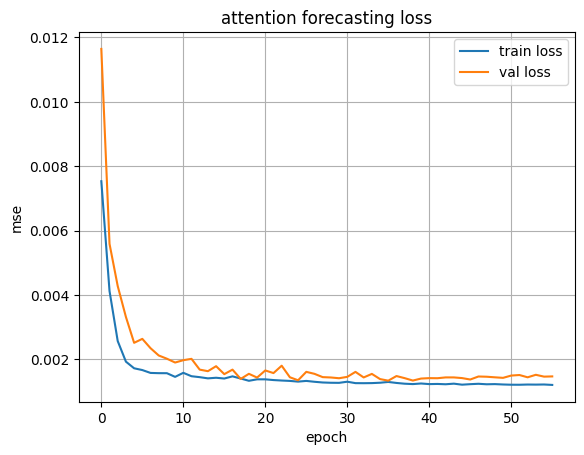

In [73]:
import matplotlib.pyplot as plt

plt.plot(history_attention.history["loss"], label="train loss")
plt.plot(history_attention.history["val_loss"], label="val loss")
plt.title("attention forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  \
0  Attention-only FW-PCA (test)          0.004967            0.004967   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.026218       0.137228             0.632176

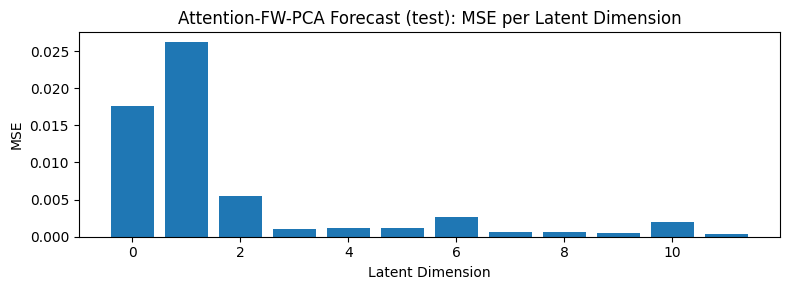

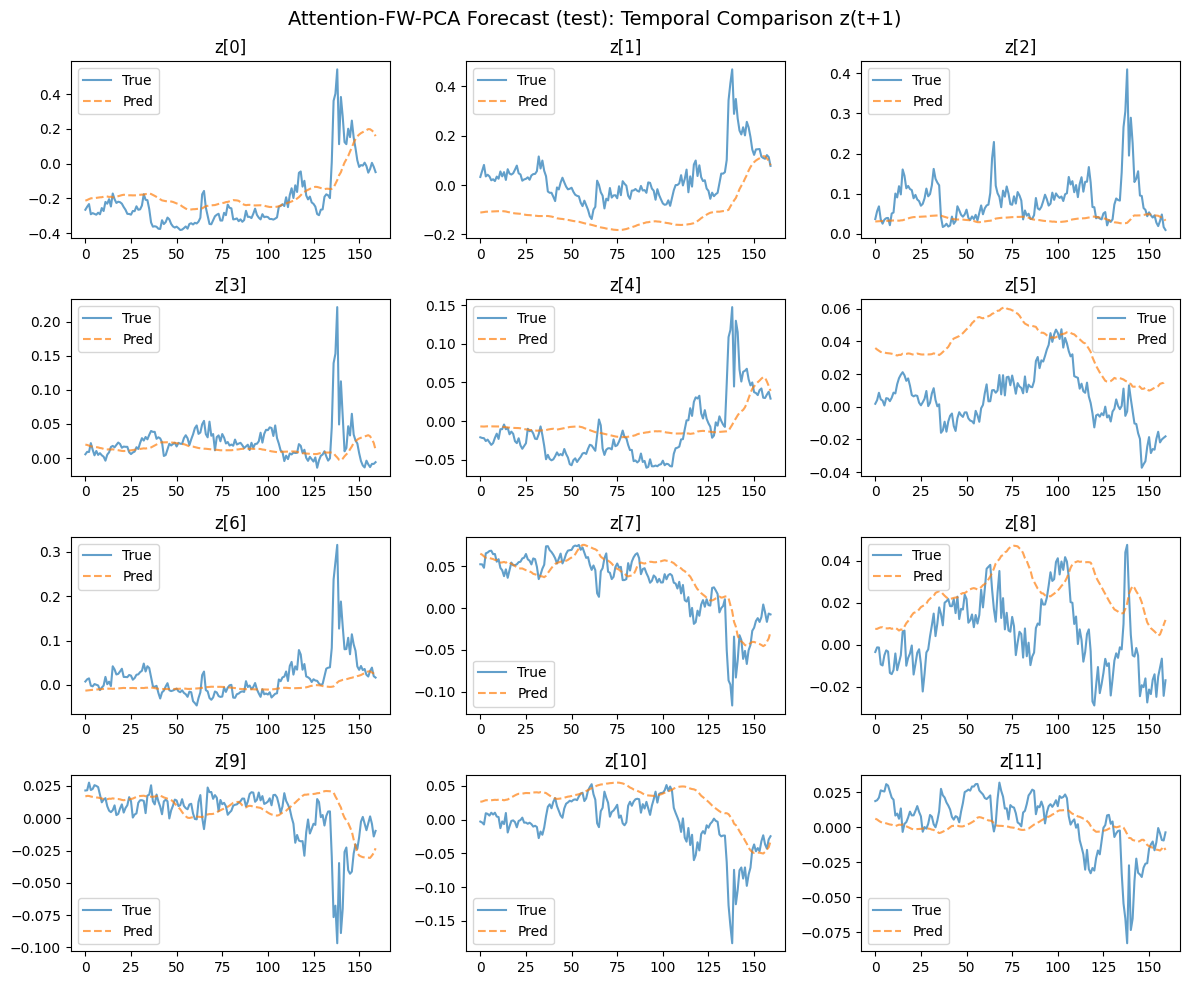

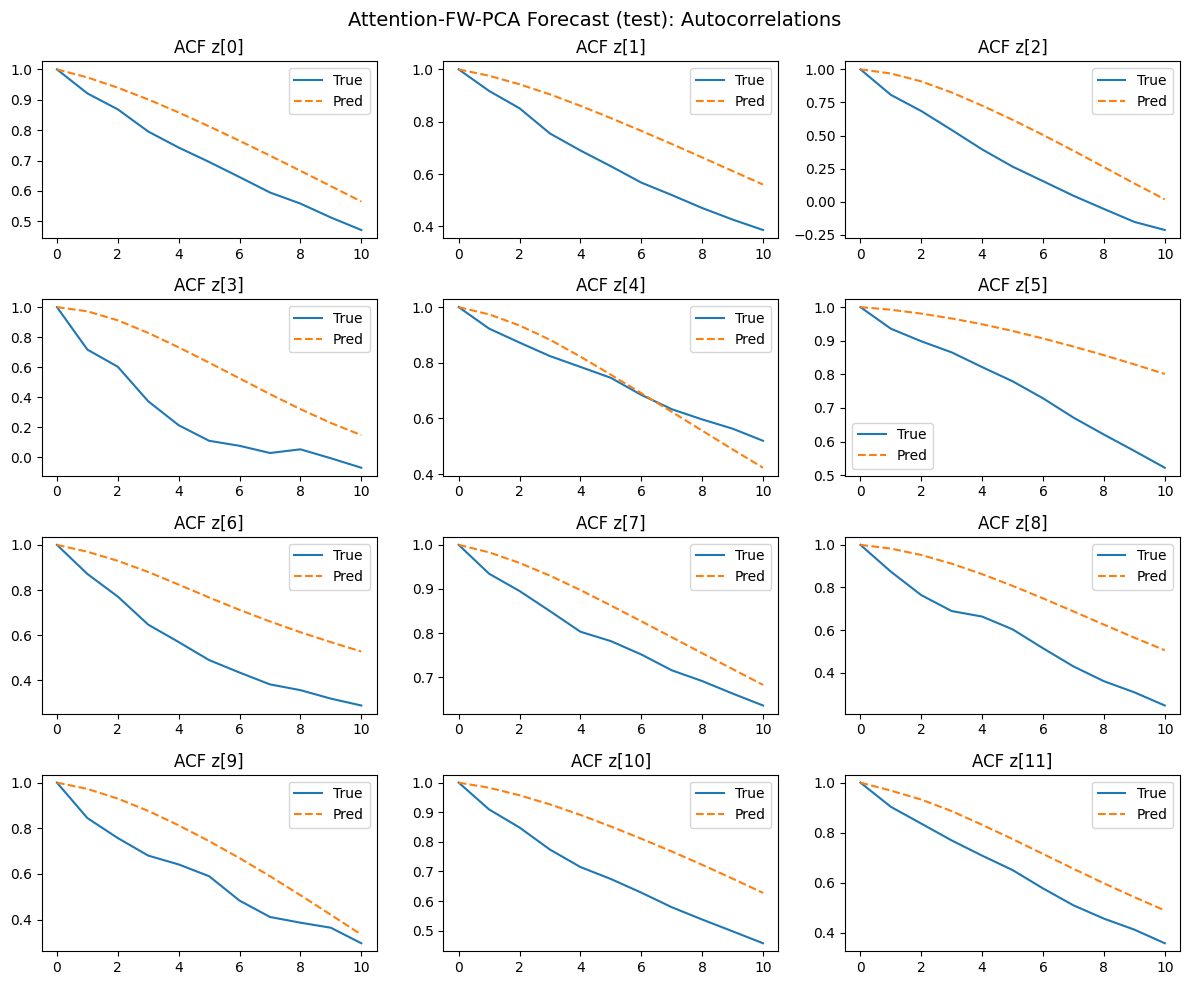

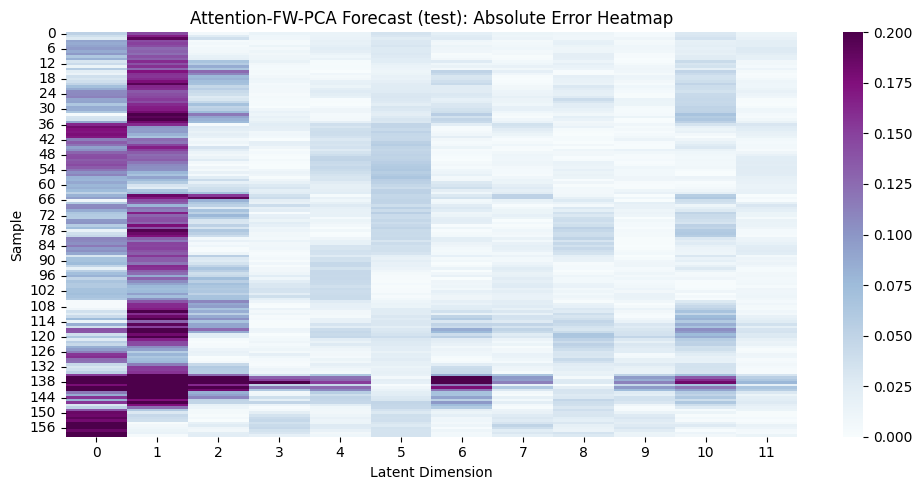

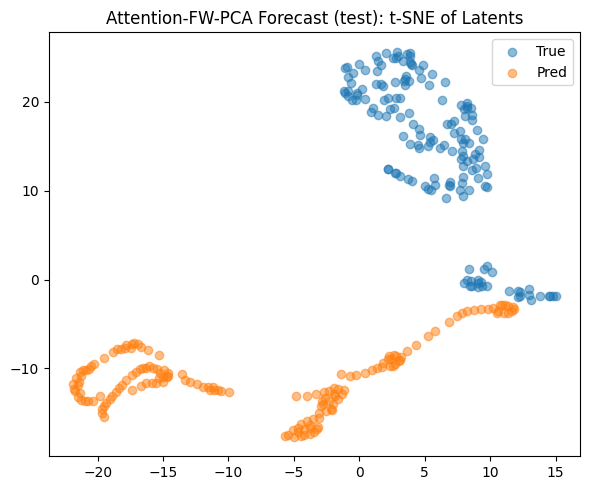

In [74]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

from utils.eval import summarize_latent_errors
from models.lstm import EncodedLatentSequence

test_gen = EncodedLatentSequence(test_dataset, encoder)

Z_pred_attn = attention_model.predict(test_gen, verbose=0)
Z_true_attn = ops.convert_to_numpy(ops.concatenate([y for _, y in test_gen], axis=0))[:len(Z_pred_attn)]

summary_attention = summarize_latent_errors(Z_true_attn, Z_pred_attn, name="Attention-only FW-PCA (test)")
display(summary_attention)

plot_latent_diagnostics(Z_true_attn, Z_pred_attn, name="Attention-FW-PCA Forecast (test)", tsne=True)

In [75]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0            LSTM-FW-PCA (test)          0.002884            0.002884   
1       LSTM-Attn-FW-PCA (test)          0.004696            0.004696   
2  Attention-only FW-PCA (test)          0.004967            0.004967   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.014301       0.107198             0.644414   
1            0.022497       0.125930             0.631869   
2            0.026218       0.137228             0.632176   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      1.0   
1                    2.0                      2.0                      2.0   
2                    3.0                      3.0                      3.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 1.0                       1.0        1.0  
1                 2.0                       3.0        2.2  
2                 3.0                       2.0        2.8

### Transformer Model Hyperparameters

- **lookback**: Number of timesteps in the input sequence (e.g., 20 days)
- **input_dim**: Total input dimension per timestep = z_dim + feature_dim
- **latent_dim**: Output dimension = dimension of z_{t+1}
- **d_model**: Dimensionality of the model's internal representation per timestep
- **n_heads**: Number of attention heads in each self-attention layer
- **ff_dim**: Hidden dimension size inside each feedforward block
- **n_layers**: Number of stacked Transformer encoder blocks
- **dropout**: Dropout rate applied after self-attention and feedforward layers


In [76]:
import models.transformer
import importlib
importlib.reload(models.transformer)

from models.transformer import TransformerForecaster
from keras.optimizers import Adam

input_dim = LATENT_DIM  # z_seq only
lr = 5e-4

transformer_model = TransformerForecaster(
    lookback=LOOKBACK,
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    d_model=128,
    n_heads=4,
    ff_dim=128,
    n_layers=6,
    dropout=0.0  # match LSTM setup
)

# Build model once with dummy input
model = transformer_model(np.zeros((1, LOOKBACK, input_dim), dtype="float32"))
transformer_model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
transformer_model.summary()


Model: "transformer_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (1, 20, 128)           │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block       │ ?                      │       297,344 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_1     │ ?                      │       297,344 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_2     │ ?                      │       297,344 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_3     │ ?                      │       297,344 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_4     │ ?                      │       297,344 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_5     │ ?                      │       297,344 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (1, 12)                │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,787,276 (6.82 MB)

 Trainable params: 1,787,276 (6.82 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from models.lstm import EncodedLatentSequence

os.makedirs("saved_models/transformer", exist_ok=True)

lr = 5e-5
transformer_model.compile(optimizer=Adam(learning_rate=lr), loss="mse")

callbacks = [
   EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
   ModelCheckpoint("saved_models/transformer/transformer_fwpca.weights.h5",
                   monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

train_gen = EncodedLatentSequence(train_dataset, encoder)
val_gen   = EncodedLatentSequence(val_dataset, encoder)

history_transformer = transformer_model.fit(
   x=train_gen,
   validation_data=val_gen,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

transformer_model.save("saved_models/transformer/transformer_model_fwpca.keras")

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 2.7339 - val_loss: 0.0634 - learning_rate: 5.0000e-05
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0545 - val_loss: 0.0566 - learning_rate: 5.0000e-05
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0152 - val_loss: 0.0250 - learning_rate: 5.0000e-05
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0115 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0083 - val_loss: 0.0056 - learning_rate: 5.0000e-05
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0150 - val_loss: 0.0267 - learning_rate: 5.0000e-05
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0083 - val_loss: 0.0062 - learning_rate: 5.0000e-05
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0152 - val_loss: 0.0172 - learning_rate: 5.0000e-05
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0092 - val_loss: 0.0103 - 

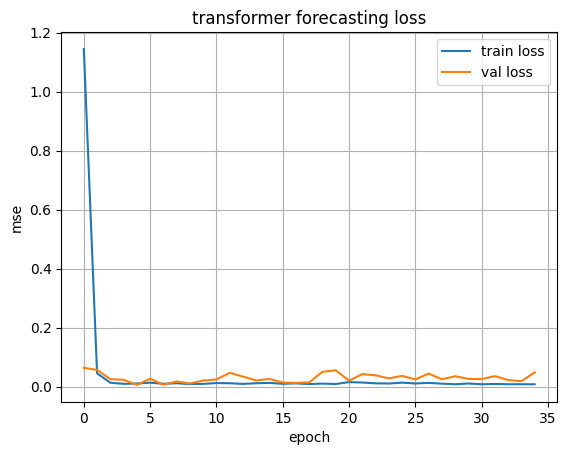

In [78]:
import matplotlib.pyplot as plt

plt.plot(history_transformer.history["loss"], label="train loss")
plt.plot(history_transformer.history["val_loss"], label="val loss")
plt.title("transformer forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  \
0  Transformer FW-PCA (test)          0.009824            0.009824   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.041794        0.07545             0.421373

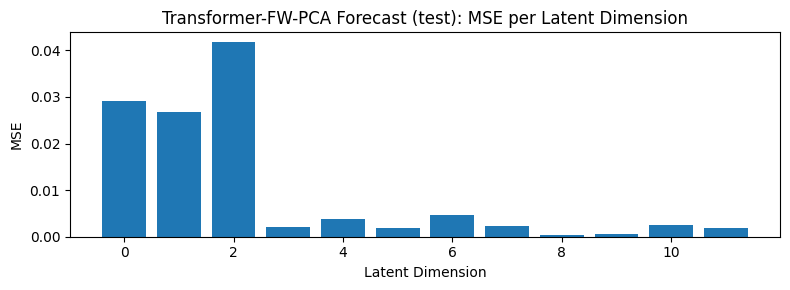

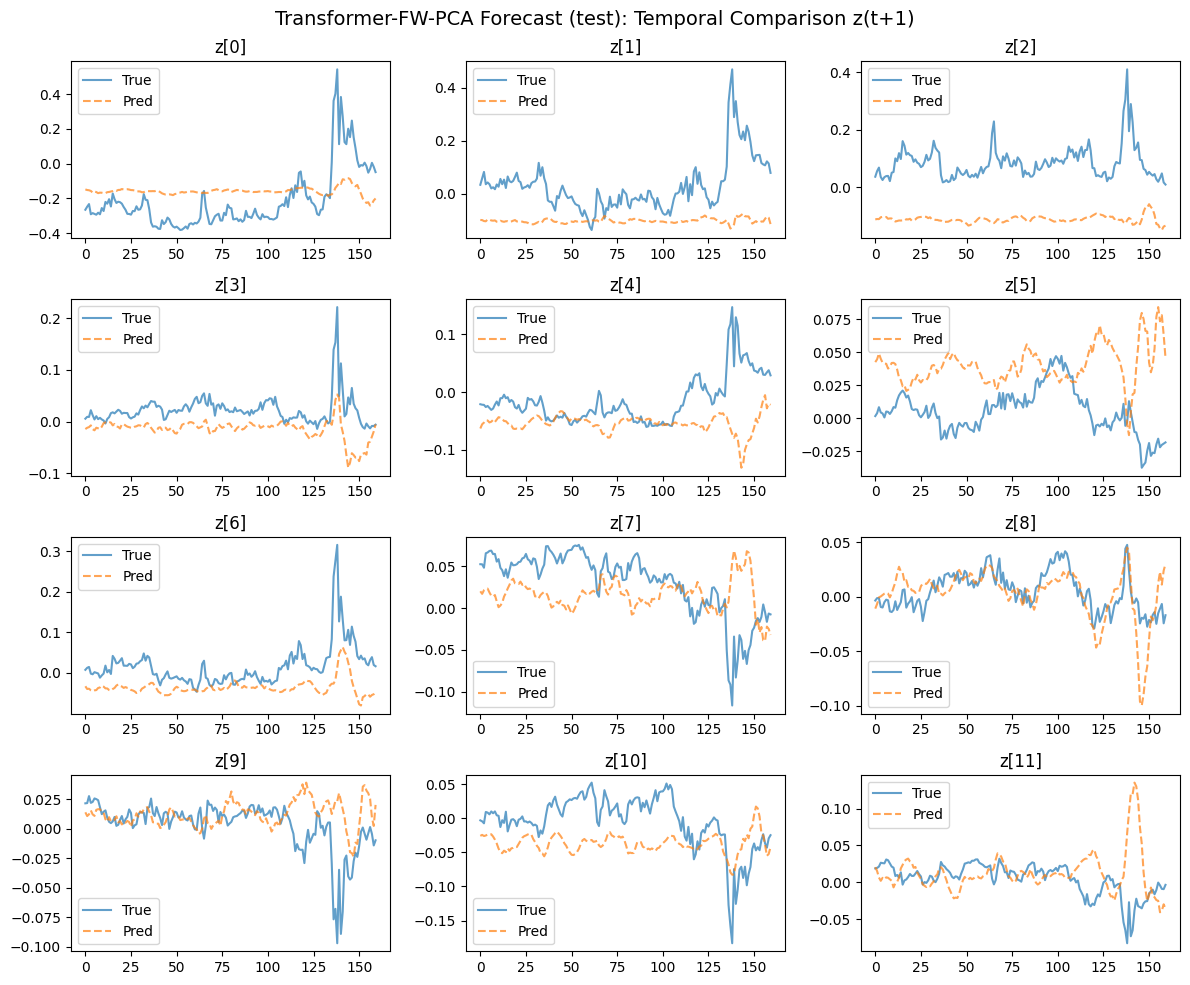

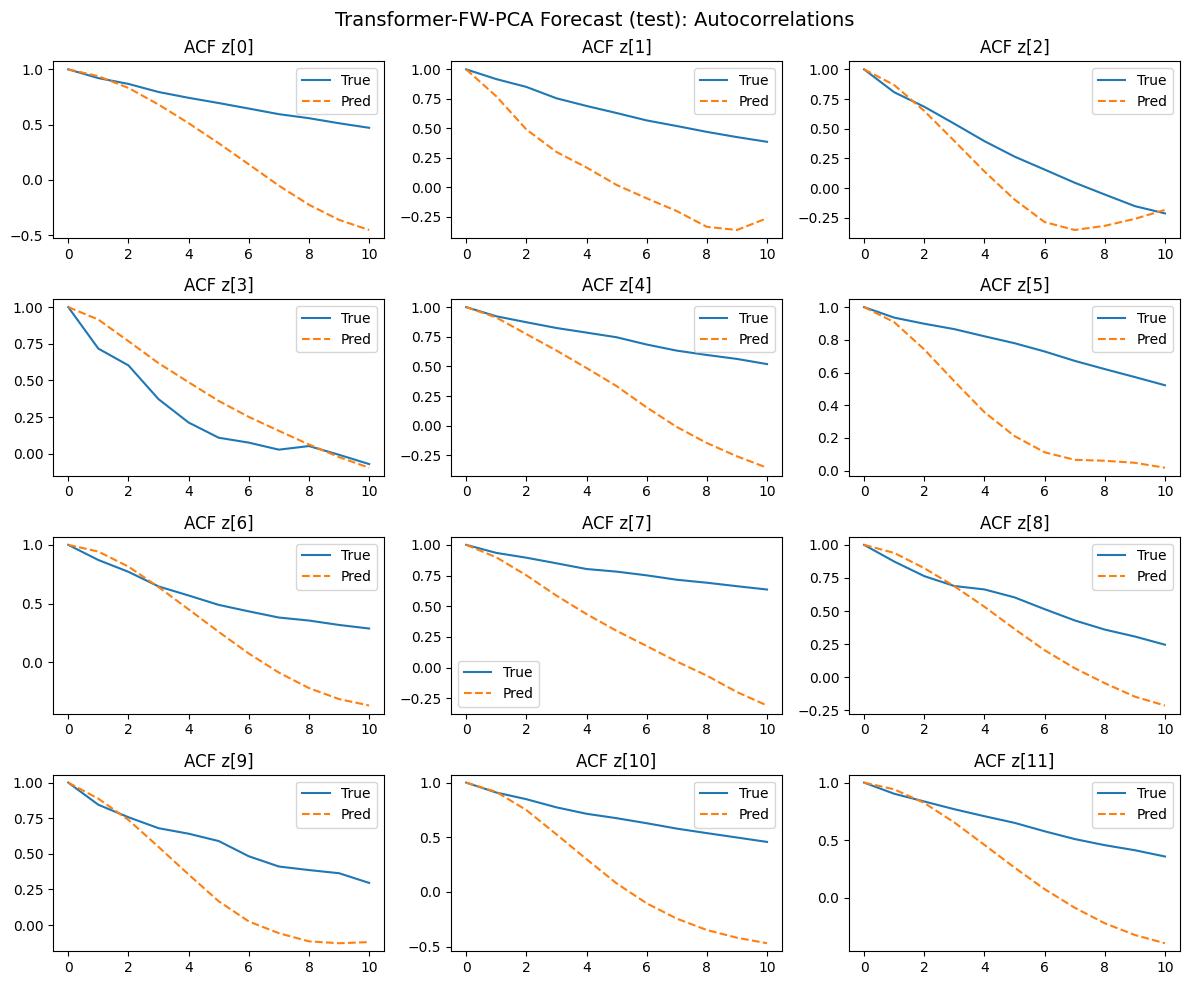

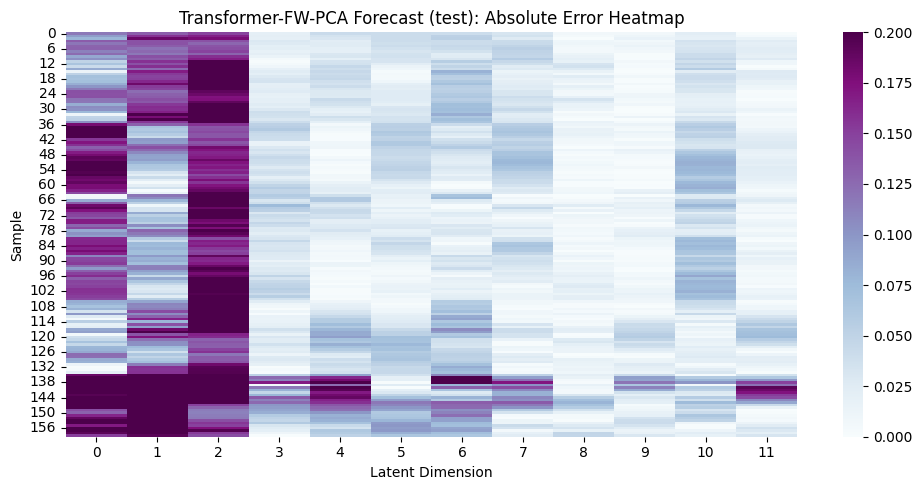

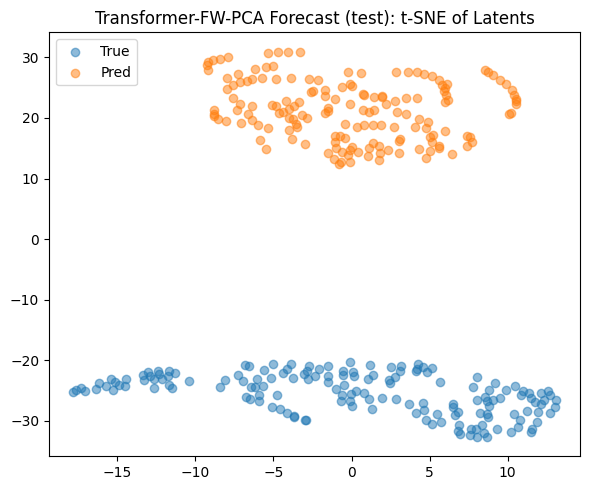

In [79]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

from utils.eval import summarize_latent_errors
from models.lstm import EncodedLatentSequence

test_gen = EncodedLatentSequence(test_dataset, encoder)

Z_pred_transformer = transformer_model.predict(test_gen, verbose=0)
Z_true_transformer = ops.convert_to_numpy(ops.concatenate([y for _, y in test_gen], axis=0))[:len(Z_pred_transformer)]

summary_transformer = summarize_latent_errors(Z_true_transformer, Z_pred_transformer, name="Transformer FW-PCA (test)")
display(summary_transformer)

plot_latent_diagnostics(Z_true_transformer, Z_pred_transformer, name="Transformer-FW-PCA Forecast (test)", tsne=True)

In [80]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    summary_transformer,
   
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0            LSTM-FW-PCA (test)          0.002884            0.002884   
1       LSTM-Attn-FW-PCA (test)          0.004696            0.004696   
2  Attention-only FW-PCA (test)          0.004967            0.004967   
3     Transformer FW-PCA (test)          0.009824            0.009824   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.014301       0.107198             0.644414   
1            0.022497       0.125930             0.631869   
2            0.026218       0.137228             0.632176   
3            0.041794       0.075450             0.421373   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      1.0   
1                    2.0                      2.0                      2.0   
2                    3.0                      3.0                      3.0   
3                    4.0                      4.0                      4.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 2.0                       1.0        1.2  
1                 3.0                       3.0        2.4  
2                 4.0                       2.0        3.0  
3                 1.0                       4.0        3.4

In [81]:
import models.transformer
import importlib
importlib.reload(models.transformer)

from models.transformer import TransformerForecasterV2

input_dim = LATENT_DIM  # z_seq only (already includes surface + features)
lr = 5e-4

transformer_model_v2 = TransformerForecasterV2(
    lookback=LOOKBACK,
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    d_model=128,
    n_heads=4,
    ff_dim=256,
    n_layers=6,
    dropout=0.0  # match LSTM config
)

# Force build for summary
dummy_input = np.zeros((1, LOOKBACK, input_dim), dtype="float32")
transformer_model_v2(dummy_input)

transformer_model_v2.compile(optimizer=Adam(learning_rate=lr), loss="mse")
transformer_model_v2.summary()


Model: "transformer_forecaster_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (1, 20, 128)           │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (20, 128)              │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_7          │ (1, 20, 128)           │       263,808 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (1, 20, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (1, 20, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_8          │ (1, 20, 128)           │       263,808 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_15          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (1, 20, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (1, 20, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_9          │ (1, 20, 128)           │       263,808 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_17          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (1, 20, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,987,212 (7.58 MB)

 Trainable params: 1,987,212 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from models.lstm import EncodedLatentSequence

os.makedirs("saved_models/transformer_v2", exist_ok=True)

lr = 5e-5
transformer_model_v2.compile(optimizer=Adam(learning_rate=lr), loss="mse")

callbacks = [
   EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
   ModelCheckpoint("saved_models/transformer_v2/transformer_v2_fwpca.weights.h5",
                   monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

train_gen = EncodedLatentSequence(train_dataset, encoder)
val_gen   = EncodedLatentSequence(val_dataset, encoder)

history_transformer_v2 = transformer_model_v2.fit(
   x=train_gen,
   validation_data=val_gen,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

transformer_model_v2.save("saved_models/transformer_v2/transformer_v2_model_fwpca.keras")

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.0552 - val_loss: 0.0838 - learning_rate: 5.0000e-05
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0697 - val_loss: 0.0318 - learning_rate: 5.0000e-05
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0313 - val_loss: 0.0175 - learning_rate: 5.0000e-05
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0285 - val_loss: 0.0448 - learning_rate: 5.0000e-05
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0242 - val_loss: 0.0470 - learning_rate: 5.0000e-05
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0220 - val_loss: 0.0244 - learning_rate: 5.0000e-05
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0161 - val_loss: 0.0265 - learning_rate: 5.0000e-05
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0181 - val_loss: 0.0188 - learning_rate: 5.0000e-05
Epoch 9/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0165 - val_loss: 0.0251 - 

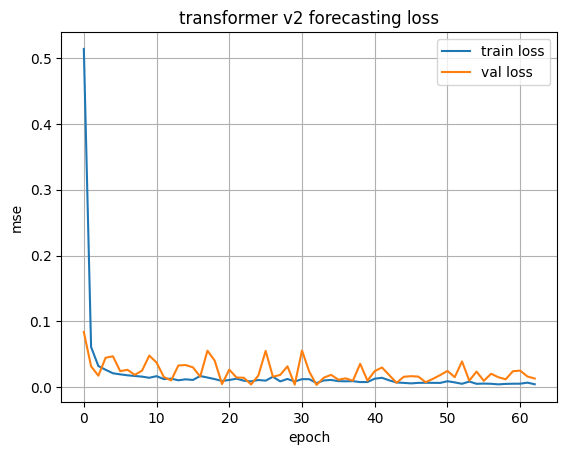

In [83]:
import matplotlib.pyplot as plt

plt.plot(history_transformer_v2.history["loss"], label="train loss")
plt.plot(history_transformer_v2.history["val_loss"], label="val loss")
plt.title("transformer v2 forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  \
0  Transformer V2 FW-PCA (test)          0.011629            0.011629   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.034009       0.298849             1.940014

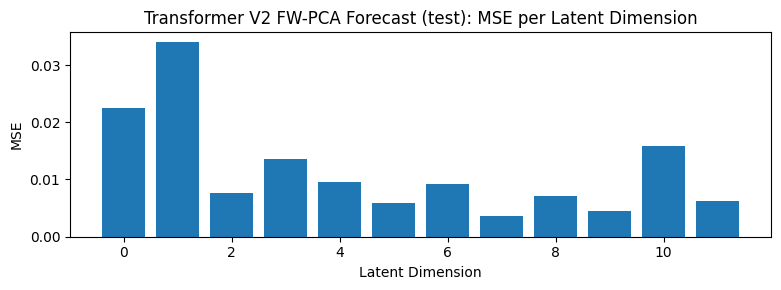

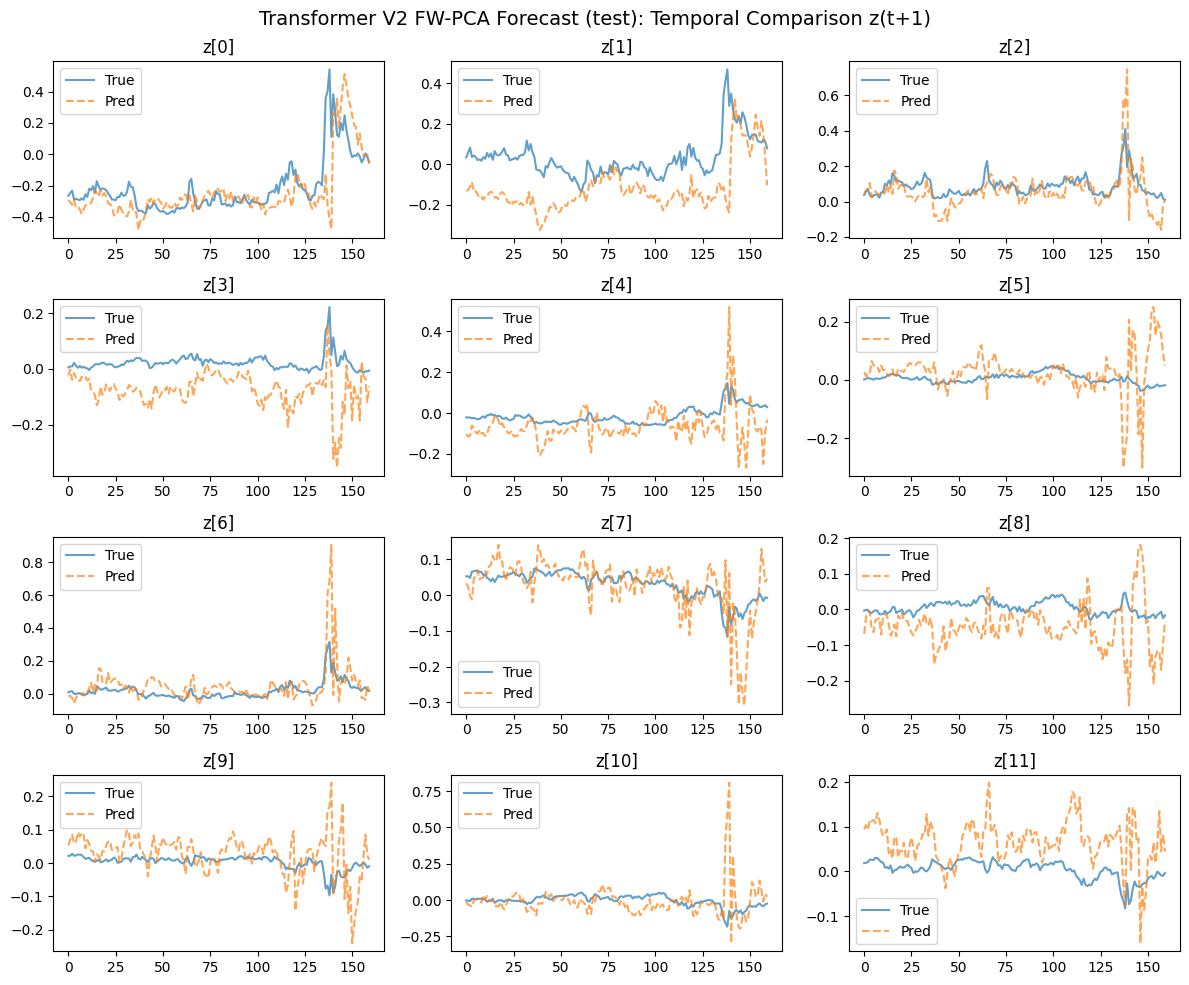

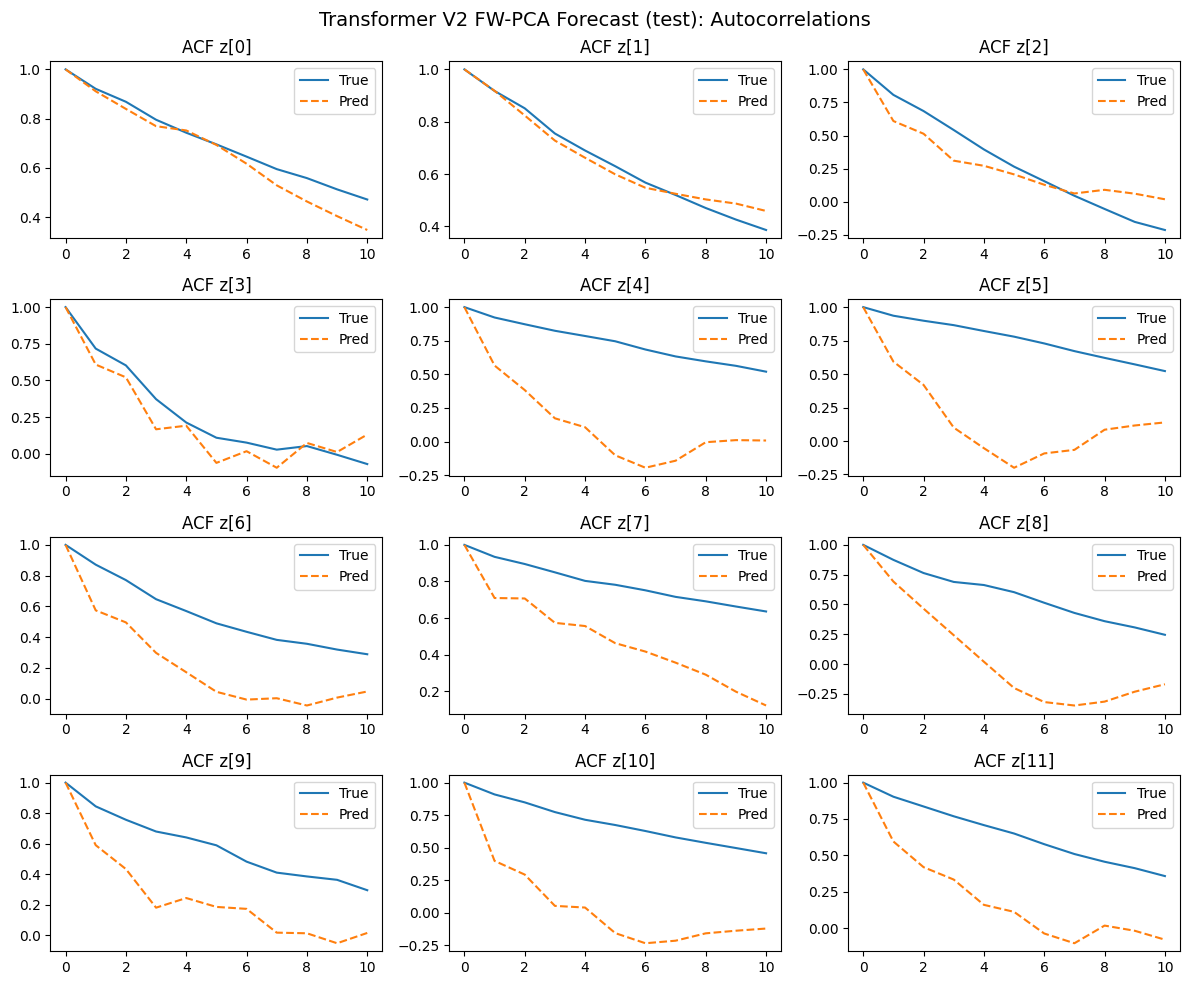

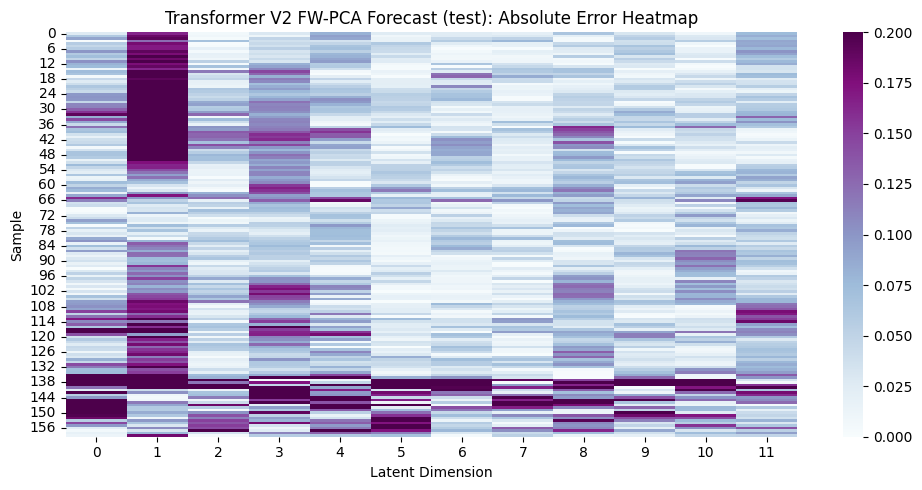

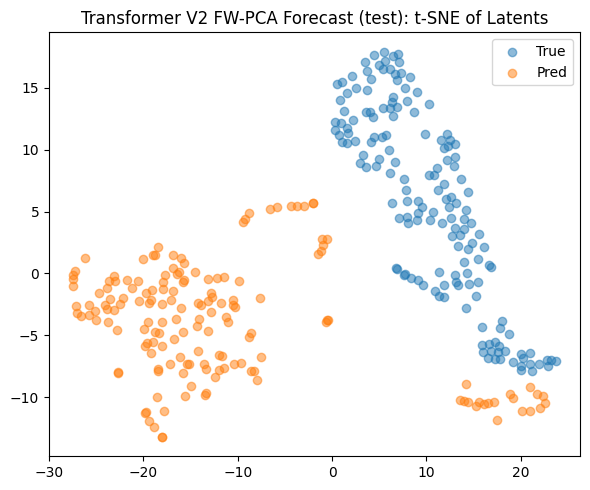

In [84]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

from utils.eval import summarize_latent_errors
from models.lstm import EncodedLatentSequence

test_gen = EncodedLatentSequence(test_dataset, encoder)

Z_pred_transformer_v2 = transformer_model_v2.predict(test_gen, verbose=0)
Z_true_transformer_v2 = ops.convert_to_numpy(ops.concatenate([y for _, y in test_gen], axis=0))[:len(Z_pred_transformer_v2)]

summary_transformer_v2 = summarize_latent_errors(Z_true_transformer_v2, Z_pred_transformer_v2, name="Transformer V2 FW-PCA (test)")
display(summary_transformer_v2)

plot_latent_diagnostics(Z_true_transformer_v2, Z_pred_transformer_v2, name="Transformer V2 FW-PCA Forecast (test)", tsne=True)

In [85]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    summary_transformer,
    summary_transformer_v2
    # 
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0            LSTM-FW-PCA (test)          0.002884            0.002884   
1       LSTM-Attn-FW-PCA (test)          0.004696            0.004696   
2  Attention-only FW-PCA (test)          0.004967            0.004967   
3     Transformer FW-PCA (test)          0.009824            0.009824   
4  Transformer V2 FW-PCA (test)          0.011629            0.011629   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.014301       0.107198             0.644414   
1            0.022497       0.125930             0.631869   
2            0.026218       0.137228             0.632176   
3            0.041794       0.075450             0.421373   
4            0.034009       0.298849             1.940014   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      1.0   
1                    2.0                      2.0                      2.0   
2                    3.0                      3.0                      3.0   
3                    4.0                      4.0                      5.0   
4                    5.0                      5.0                      4.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 2.0                       2.0        1.4  
1                 3.0                       4.0        2.6  
2                 4.0                       3.0        3.2  
3                 1.0                       5.0        3.8  
4                 5.0                       1.0        4.0

In [86]:
from models.gru import build_gru_forecaster_augmented

gru_model = build_gru_forecaster_augmented(
    lookback=LOOKBACK,
    input_dim=LATENT_DIM,  # since z_seq already encodes [surface + features]
    latent_dim=LATENT_DIM,
    lr=1e-5
)
gru_model.summary()


Model: "gru_forecaster_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ delta_z (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_z_out (Add)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from models.gru import build_gru_forecaster_augmented
from models.lstm import EncodedLatentSequence

os.makedirs("saved_models/gru", exist_ok=True)

callbacks = [
   EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True,min_delta=5e-5),
   ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
   ModelCheckpoint("saved_models/gru/gru_fwpca.weights.h5",
                   monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

train_gen = EncodedLatentSequence(train_dataset, encoder)
val_gen   = EncodedLatentSequence(val_dataset, encoder)

history_gru = gru_model.fit(
   x=train_gen,
   validation_data=val_gen,
   epochs=300,
   callbacks=callbacks,
   verbose=1
)

gru_model.save("saved_models/gru/gru_model_fwpca.keras")

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 9.8397e-04 - val_loss: 9.5856e-04 - learning_rate: 1.0000e-05
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 6.7462e-04 - val_loss: 8.8385e-04 - learning_rate: 1.0000e-05
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 8.1979e-04 - val_loss: 8.0162e-04 - learning_rate: 1.0000e-05
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 7.3651e-04 - val_loss: 7.4160e-04 - learning_rate: 1.0000e-05
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 6.0982e-04 - val_loss: 6.8096e-04 - learning_rate: 1.0000e-05
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 5.4376e-04 - val_loss: 6.2572e-04 - learning_rate: 1.0000e-05
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 6.2078e-04 - val_loss: 5.7608e-04 - learning_rate: 1.0000e-05
Epoch 8/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 5.3178e-04 - val_loss: 5.3737e-04 - learning_rate: 1.0000e-05
Epoch 9/300
26/26 ━━━━━

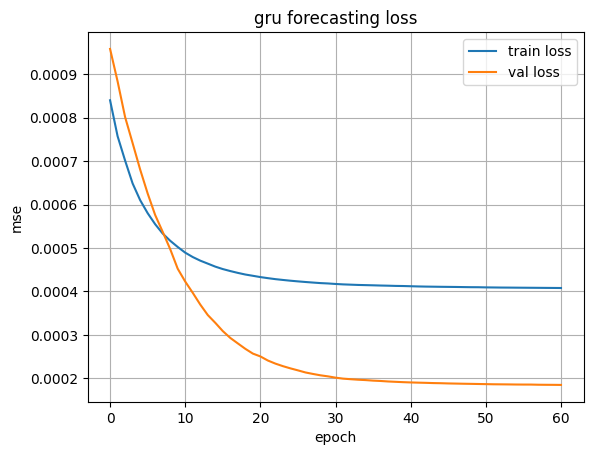

In [88]:
import matplotlib.pyplot as plt

plt.plot(history_gru.history["loss"], label="train loss")
plt.plot(history_gru.history["val_loss"], label="val loss")
plt.title("gru forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0  GRU-GBO (test)            0.0008              0.0008            0.004336   

   acf_diff_mean  var_ratio_pred/true  
0       0.017614             0.972758

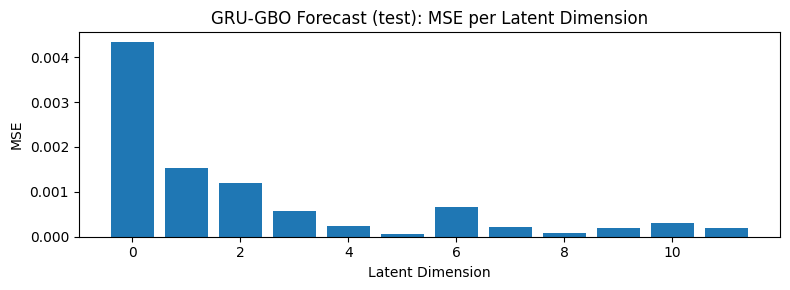

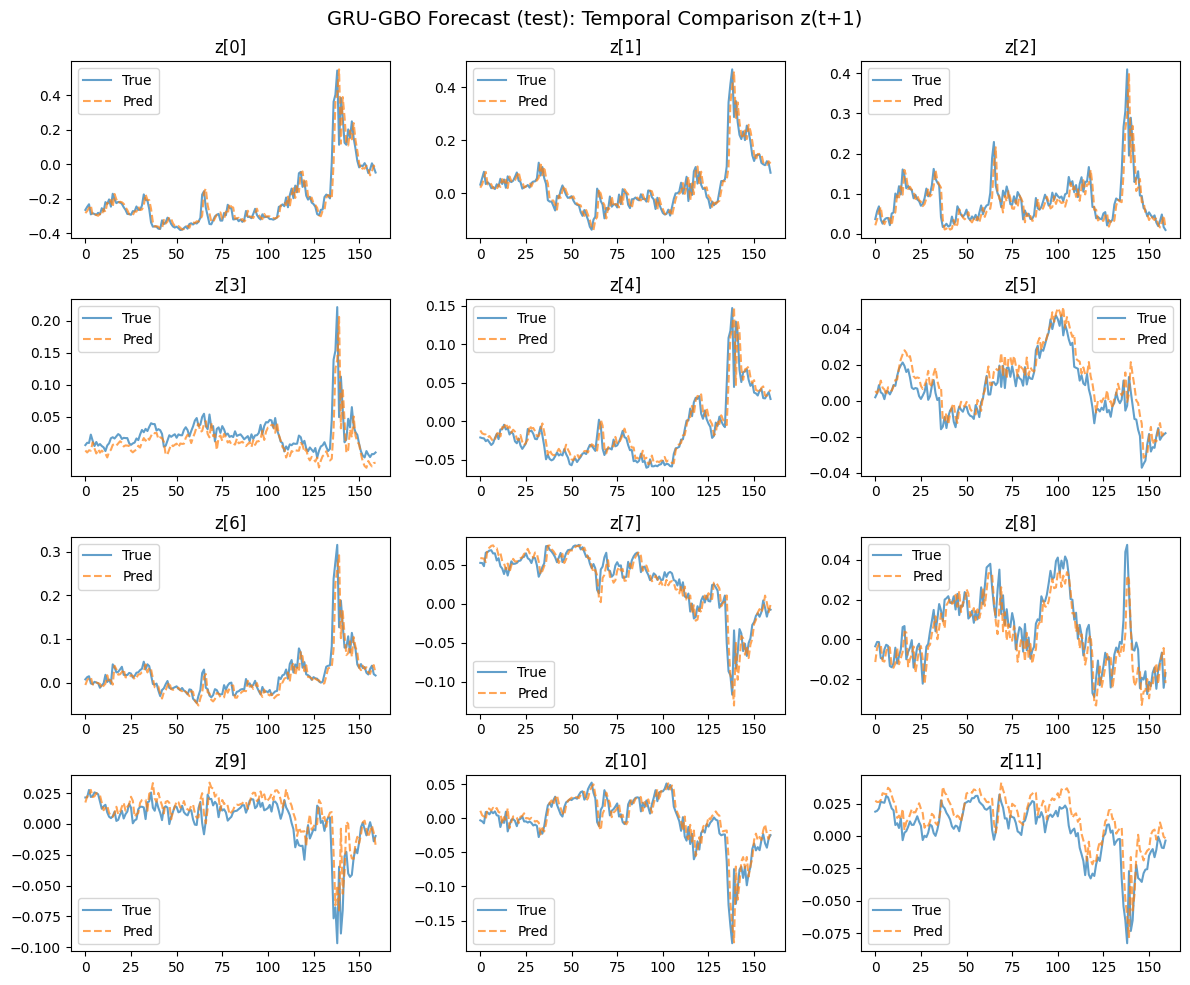

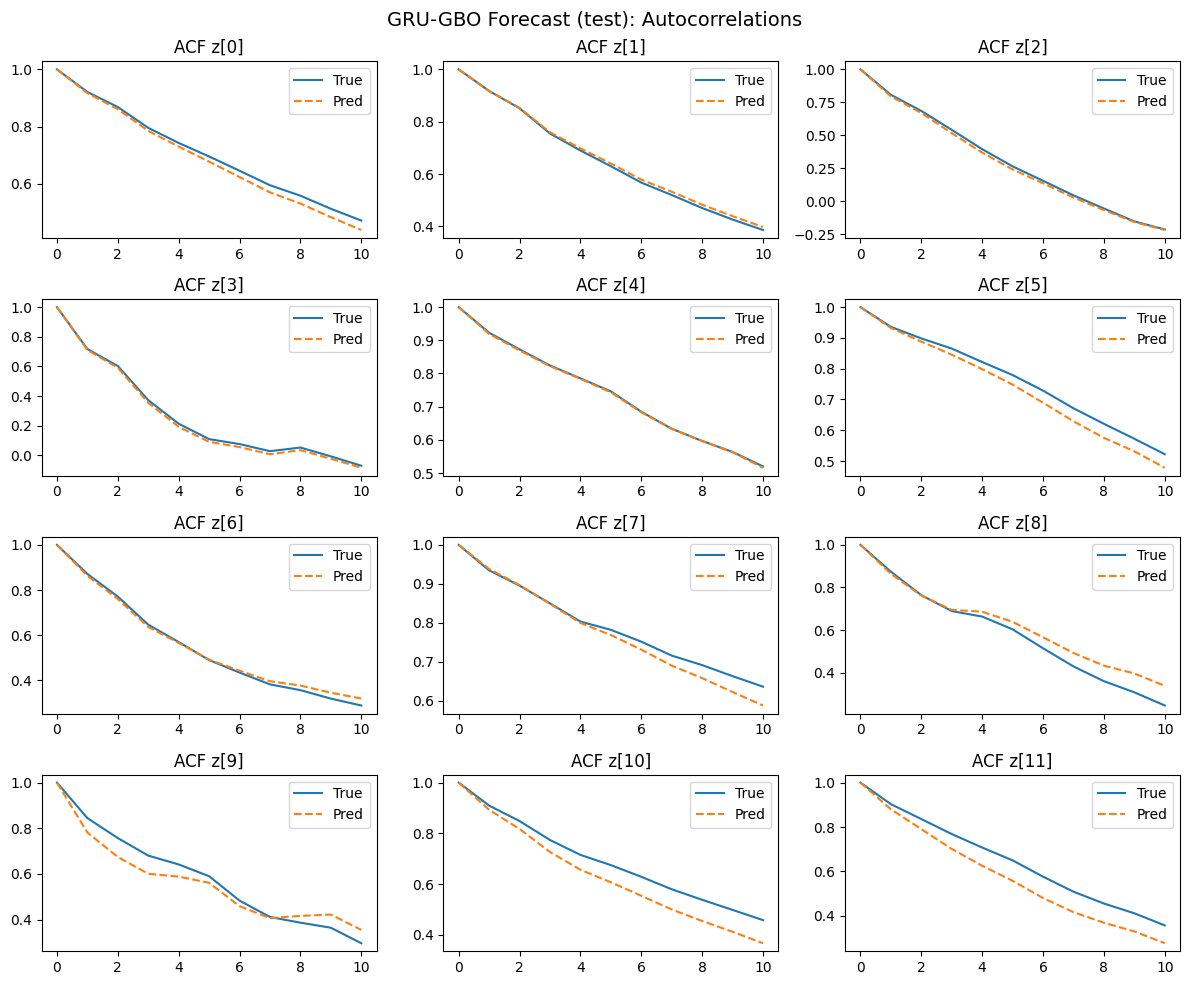

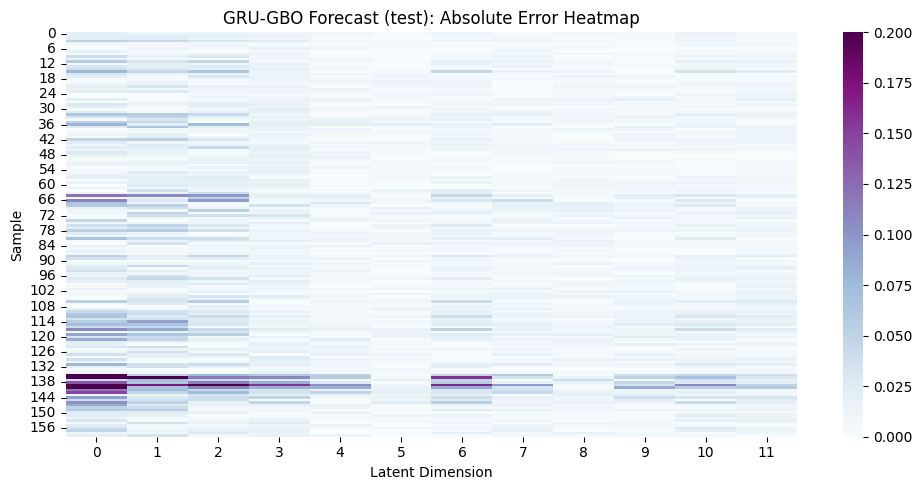

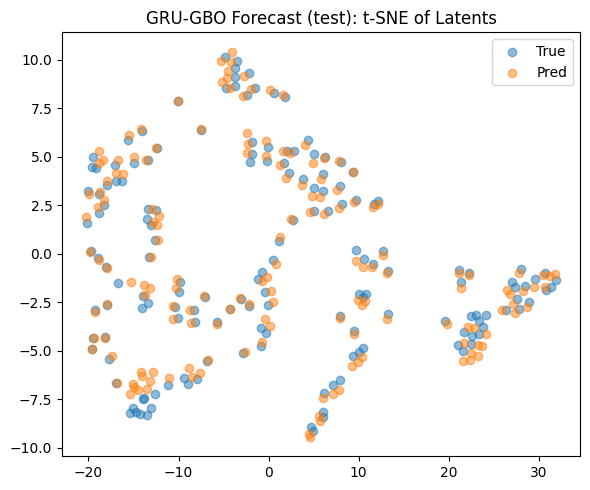

In [89]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

from utils.eval import summarize_latent_errors
from models.lstm import EncodedLatentSequence

test_gen = EncodedLatentSequence(test_dataset, encoder)

Z_pred_gru = gru_model.predict(test_gen, verbose=0)
Z_true_gru = ops.convert_to_numpy(ops.concatenate([y for _, y in test_gen], axis=0))[:len(Z_pred_gru)]

summary_gru = summarize_latent_errors(Z_true_gru, Z_pred_gru, name="GRU-GBO (test)")
display(summary_gru)

plot_latent_diagnostics(Z_true_gru, Z_pred_gru, name="GRU-GBO Forecast (test)", tsne=True)

In [90]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    summary_transformer,
    summary_transformer_v2,
    summary_gru,
    # add summary_gru, summary_transformer, etc.
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0                GRU-GBO (test)          0.000800            0.000800   
1            LSTM-FW-PCA (test)          0.002884            0.002884   
2       LSTM-Attn-FW-PCA (test)          0.004696            0.004696   
3  Attention-only FW-PCA (test)          0.004967            0.004967   
4     Transformer FW-PCA (test)          0.009824            0.009824   
5  Transformer V2 FW-PCA (test)          0.011629            0.011629   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.004336       0.017614             0.972758   
1            0.014301       0.107198             0.644414   
2            0.022497       0.125930             0.631869   
3            0.026218       0.137228             0.632176   
4            0.041794       0.075450             0.421373   
5            0.034009       0.298849             1.940014   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      1.0   
1                    2.0                      2.0                      2.0   
2                    3.0                      3.0                      3.0   
3                    4.0                      4.0                      4.0   
4                    5.0                      5.0                      6.0   
5                    6.0                      6.0                      5.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 1.0                       2.0        1.2  
1                 3.0                       3.0        2.4  
2                 4.0                       5.0        3.6  
3                 5.0                       4.0        4.2  
4                 2.0                       6.0        4.8  
5                 6.0                       1.0        4.8

FW-PCA + Forecast RMSE on True Surface: 0.0006


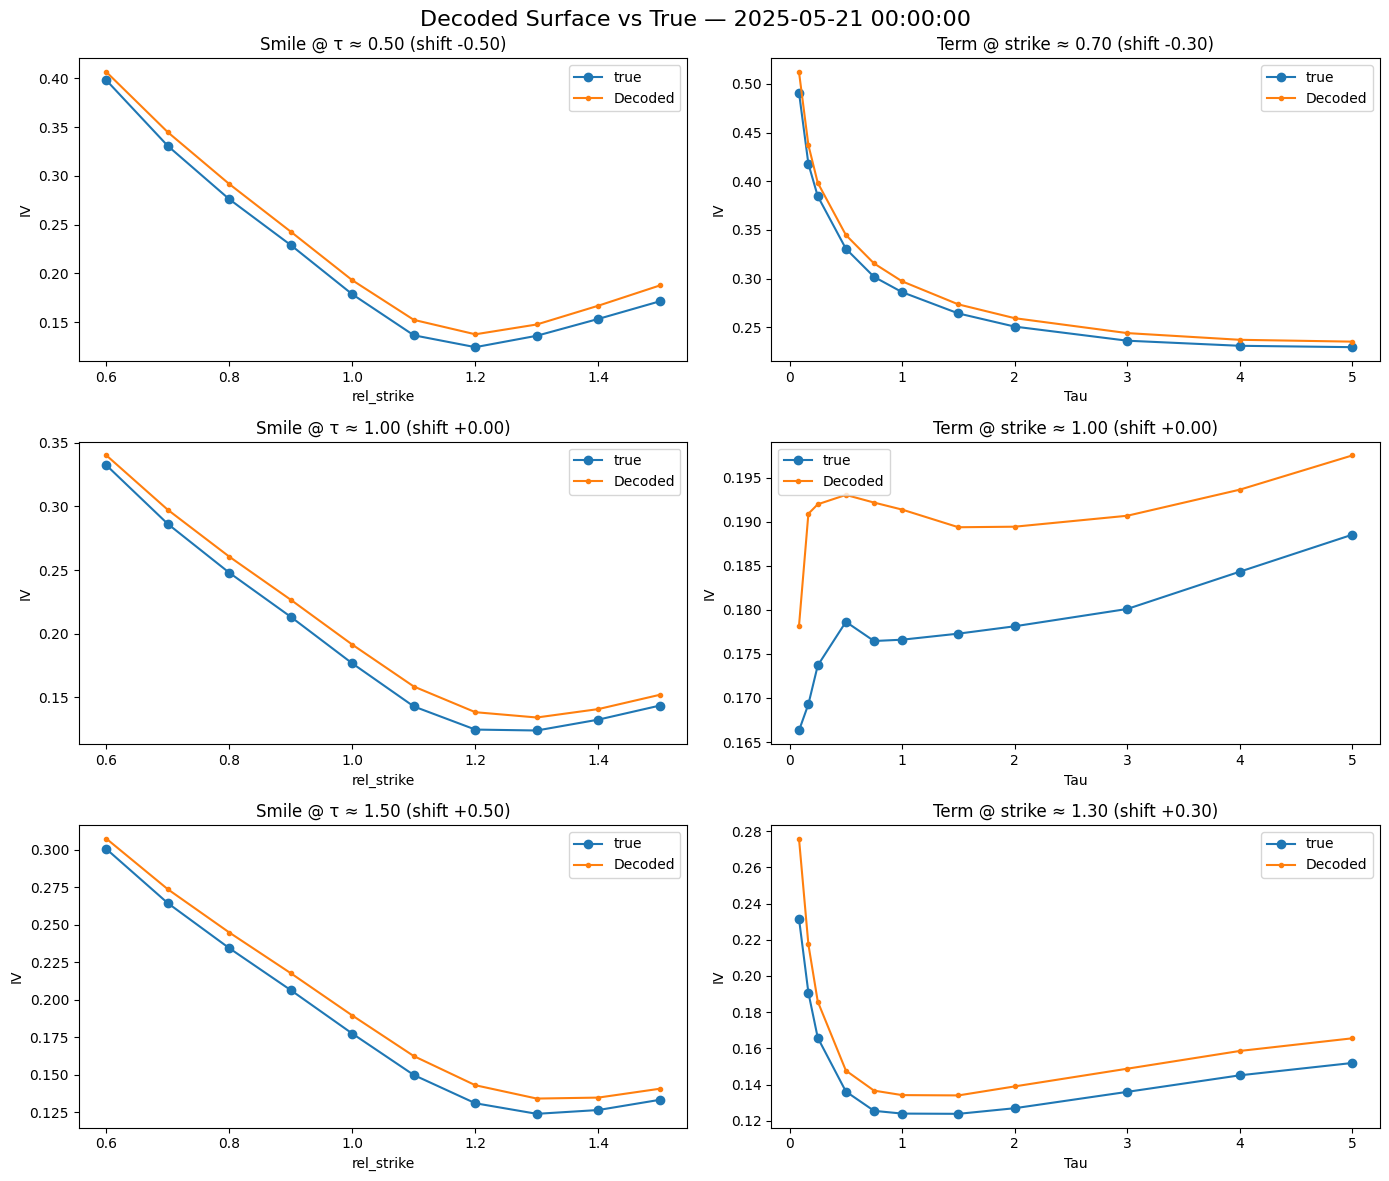

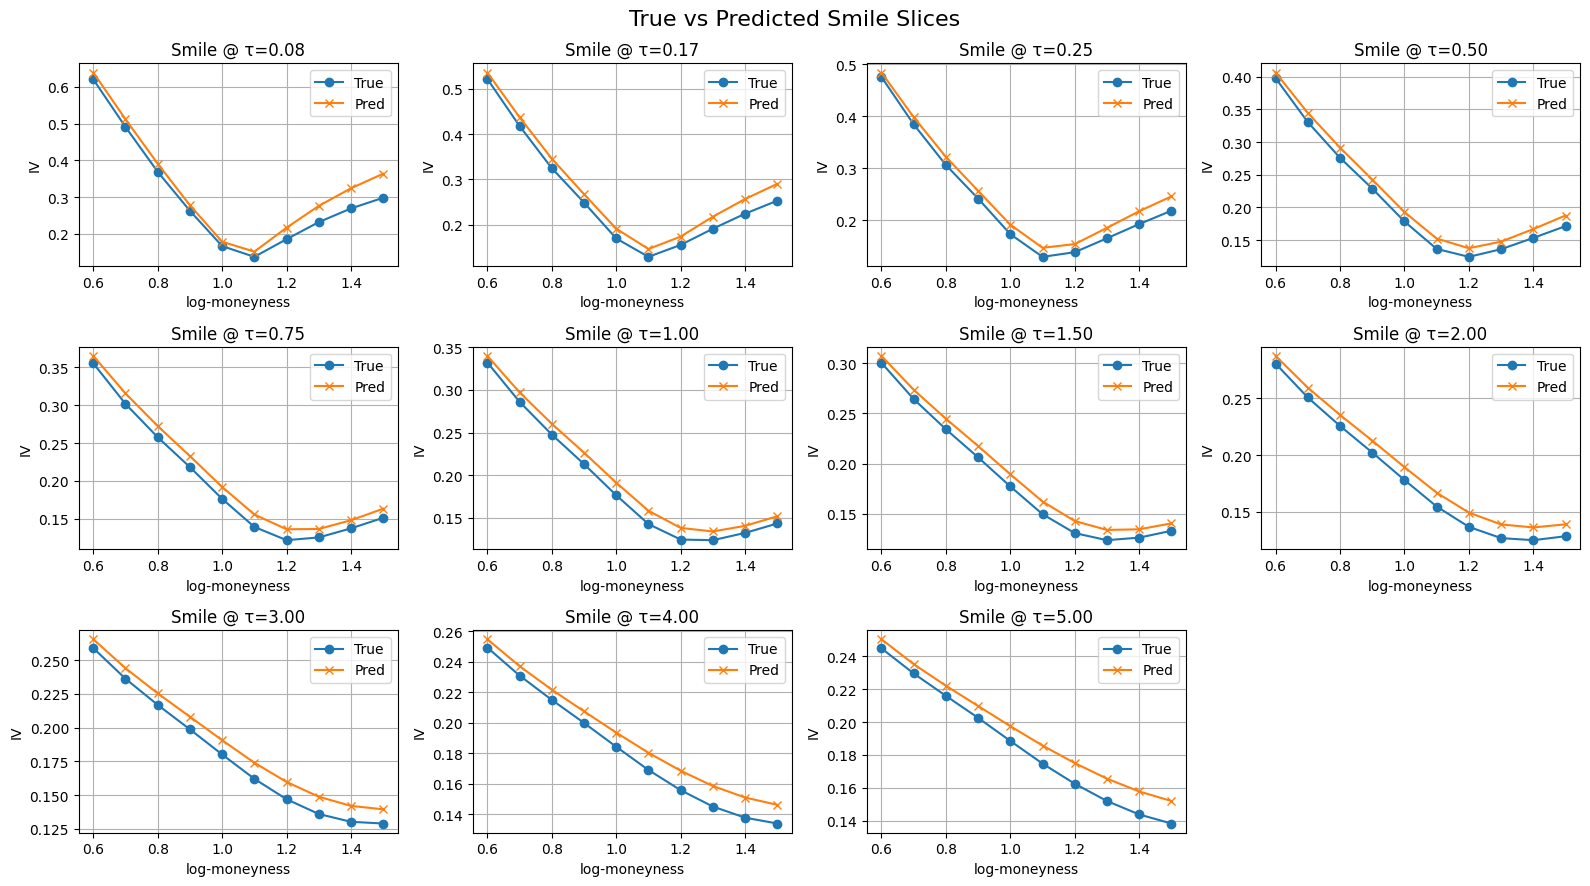

In [91]:
from data.dataset import FeatureToSurfaceDataset
import pandas as pd
from sklearn.metrics import mean_squared_error
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison

full_dataset = FeatureToSurfaceDataset(
   surface_tensor=tensors["surface_tensor"],
   feature_tensor=X_feat_tensor,
   date_tensor=tensors["date_tensor"],
   batch_size=None
)
Z_pred = gru_model.predict(test_gen, verbose=0)

X_combined_tensor = full_dataset.to_tensor()
flat_len = M * K
X_surface_all = ops.convert_to_numpy(X_combined_tensor[:, :flat_len])

X_recon = encoder.inverse_transform(Z_pred)

test_indices = ops.convert_to_numpy(test_dataset.global_indices)[-len(Z_pred):]
X_true_flat = X_surface_all[test_indices]

rmse_surface = mean_squared_error(X_true_flat, X_recon)
print(f"FW-PCA + Forecast RMSE on True Surface: {rmse_surface:.4f}")

recon_surface_t = X_recon[-1].reshape(M, K)
true_surface_t = X_true_flat[-1].reshape(M, K)
decoded_date = tensors["date_tensor"][test_indices[-1]]

plot_iv_slices_shifts(
   true_surface=true_surface_t,
   decoded_surface=recon_surface_t,
   taus=tensors["taus"],
   rel_strikes=tensors["rel_strikes"],
   decoded_date=decoded_date,
   target_tau=TARGET_TAU,
   target_strike=TARGET_STRIKE
)

plot_smile_slices_comparison(
   true_surface=true_surface_t,
   pred_surface=recon_surface_t,
   rel_strikes=tensors["rel_strikes"],
   taus=tensors["taus"]
)